**AIR QUALITY PREDICTION USING ENSEMBLE AND DEEP LEARNING MODELS**

In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.4 MB/s eta 0:00:00


In [2]:
import os                          # operating system interfaces
import glob                        # working with OS pathnames
import time                        # time processing
import numpy as np                 # linear algebra
import pandas as pd                # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt    # data visualization purposes
import seaborn as sns              # statistical data visualization
sns.set_theme()
from google.colab import drive
drive.mount('/content/drive')

# sklearn imports
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    HistGradientBoostingRegressor
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)
from sklearn.model_selection import (
    cross_val_score,
    TimeSeriesSplit,
    RandomizedSearchCV
)

import xgboost as xgb                       # Extreme Gradient Boosting library
from IPython.display import clear_output    # Display function to clear notebook cell's output

Mounted at /content/drive


In [3]:
# How many cores to use. Put -1 to use all cores.
CORE = -1

# Random variable for having consistent results between runs
RANDOM_STATE = 18

# Dataset's path location
DATA_PATH = '/content/drive/MyDrive/DATA'

**Link for data Download:**
https://drive.google.com/drive/folders/1plr0mHo6_435JiEL3IQLoEilPUsyx2sG?usp=sharing

## Load State Information

First we define the state and its appropriate code for reference as well as all the available metrics.

In [4]:
df_states = pd.read_csv(f'{DATA_PATH}/stations_info.csv')
df_states.drop(columns=['agency', 'station_location', 'start_month'], inplace=True)
df_states.head()

,file_name,state,city,start_month_num,start_year
0,AP001,Andhra Pradesh,Tirupati,7,2016
1,AP002,Andhra Pradesh,Vijayawada,5,2017
2,AP003,Andhra Pradesh,Visakhapatnam,7,2017
3,AP004,Andhra Pradesh,Rajamahendravaram,9,2017
4,AP005,Andhra Pradesh,Amaravati,11,2017


creating a function for combining all agency measurements in a given state.

In [5]:
def STATE_DATA_COMB(state_name):
    '''
    Combine all state files into a single dataframe and attaching the city information.

    Parameters
    ----------
        state_name (str): The name of the state

    Return
    ------
        df (DataFrame): The combined dataframe from all files of a specific state
    '''

    state_code = df_states[df_states['state'] == state_name]['file_name'].iloc[0][:2]
    state_files = glob.glob(f'{DATA_PATH}/{state_code}*.csv')
    print(f'Combining a total of {len(state_files)} files...\n')

    combined_df = []

    for state_file in state_files:
        file_name = state_file.split(f'{DATA_PATH}/')[1][0:-4]
        file_df = pd.read_csv(state_file)
        file_df['city'] = df_states[df_states['file_name'] == file_name]['city'].values[0]
        file_df['city'] = file_df['city'].astype('string')
        combined_df.append(file_df)

    return pd.concat(combined_df)

In order to understand the properties of the dataset provided, I will take a closer look on the measurements for India's capital state, Delhi.

In [6]:
df = STATE_DATA_COMB('Delhi')
df.info()

Combining a total of 40 files...

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2796171 entries, 0 to 20841
Data columns (total 60 columns):
 #   Column               Dtype  
---  ------               -----  
 0   From Date            object 
 1   To Date              object 
 2   PM2.5 (ug/m3)        float64
 3   PM10 (ug/m3)         float64
 4   NO (ug/m3)           float64
 5   NO2 (ug/m3)          float64
 6   NOx (ppb)            float64
 7   NH3 (ug/m3)          float64
 8   SO2 (ug/m3)          float64
 9   CO (mg/m3)           float64
 10  Ozone (ug/m3)        float64
 11  Benzene (ug/m3)      float64
 12  Toluene (ug/m3)      float64
 13  Eth-Benzene (ug/m3)  float64
 14  MP-Xylene (ug/m3)    float64
 15  O Xylene (ug/m3)     float64
 16  Temp (degree C)      float64
 17  RH (%)               float64
 18  WS (m/s)             float64
 19  WD (deg)             float64
 20  SR (W/mt2)           float64
 21  BP (mmHg)            float64
 22  VWS (m/s)            float64
 23  


## Data Preprocessing


In [7]:
# Function to set the 'From Date' column as the datetime index of the DataFrame
def df_index(df):
    # Drops the 'To Date' column as it's not needed for indexing
    df = df.drop(columns='To Date')

    # Converts the 'From Date' column to datetime format for proper indexing
    df['From Date'] = pd.to_datetime(df['From Date'])

    # Renames the 'From Date' column to 'datetime' to reflect its content more accurately
    df = df.rename(columns={'From Date': 'datetime'})

    # Sets the 'datetime' column as the index of the DataFrame, making it easier to work with time series data
    return df.set_index('datetime')

In [8]:
df = df_index(df)
df.head(2)

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),...,Benzene (),WD (),Temp (ug/m3),SR (),RH (),BP (),SO2 (),Eth-Benzene (),Xylene (),CH4 ()
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,NaN,NaN,68.69,132.78,201.47,NaN,3.20,1.21,5.76,54.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 01:00:00,NaN,NaN,12.42,65.33,77.75,NaN,1.03,NaN,1.87,32.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Feature Reduction

In [9]:
# Helper function to plot groups of data into subplots
def f_similarities(df, feature_groups, columns=2):
    # Calculate the number of rows needed in the subplot grid
    rows = int((len(feature_groups)/columns)//1)

    # Create a subplot grid with the specified number of rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(13, 4*rows))
    # Adjust the layout to prevent overlapping
    fig.tight_layout(pad=3.0)

    # Initialize row and column counters for placing subplots
    row_num = 0
    col_num = 0
    # Iterate over each feature group and its position
    for pos, group in enumerate(feature_groups):
        # Check if a new row should start based on the current column count
        if pos % columns == 0 and pos != 0:
            row_num += 1  # Move to the next row
            col_num = 0   # Reset the column counter

        # Iterate over each feature within the current group
        for feature in feature_groups[group]:
            # Filter the data for the current feature and calculate yearly mean
            df_feature = df[df[feature].notnull()][feature]
            df_feature = df_feature.groupby([df_feature.index.year]).mean(numeric_only=True)
            # Plot the feature data on the current subplot axis
            sns.lineplot(data=df_feature, label=feature, ax=axes[row_num, col_num])
        # Set the title of the subplot to the current feature group's name
        axes[row_num, col_num].set_title(group)
        # Remove x labels for a cleaner look
        axes[row_num, col_num].set(xlabel=None)
        # Move to the next column for the next subplot
        col_num += 1

    # Show the plot with all subplots
    plt.plot()

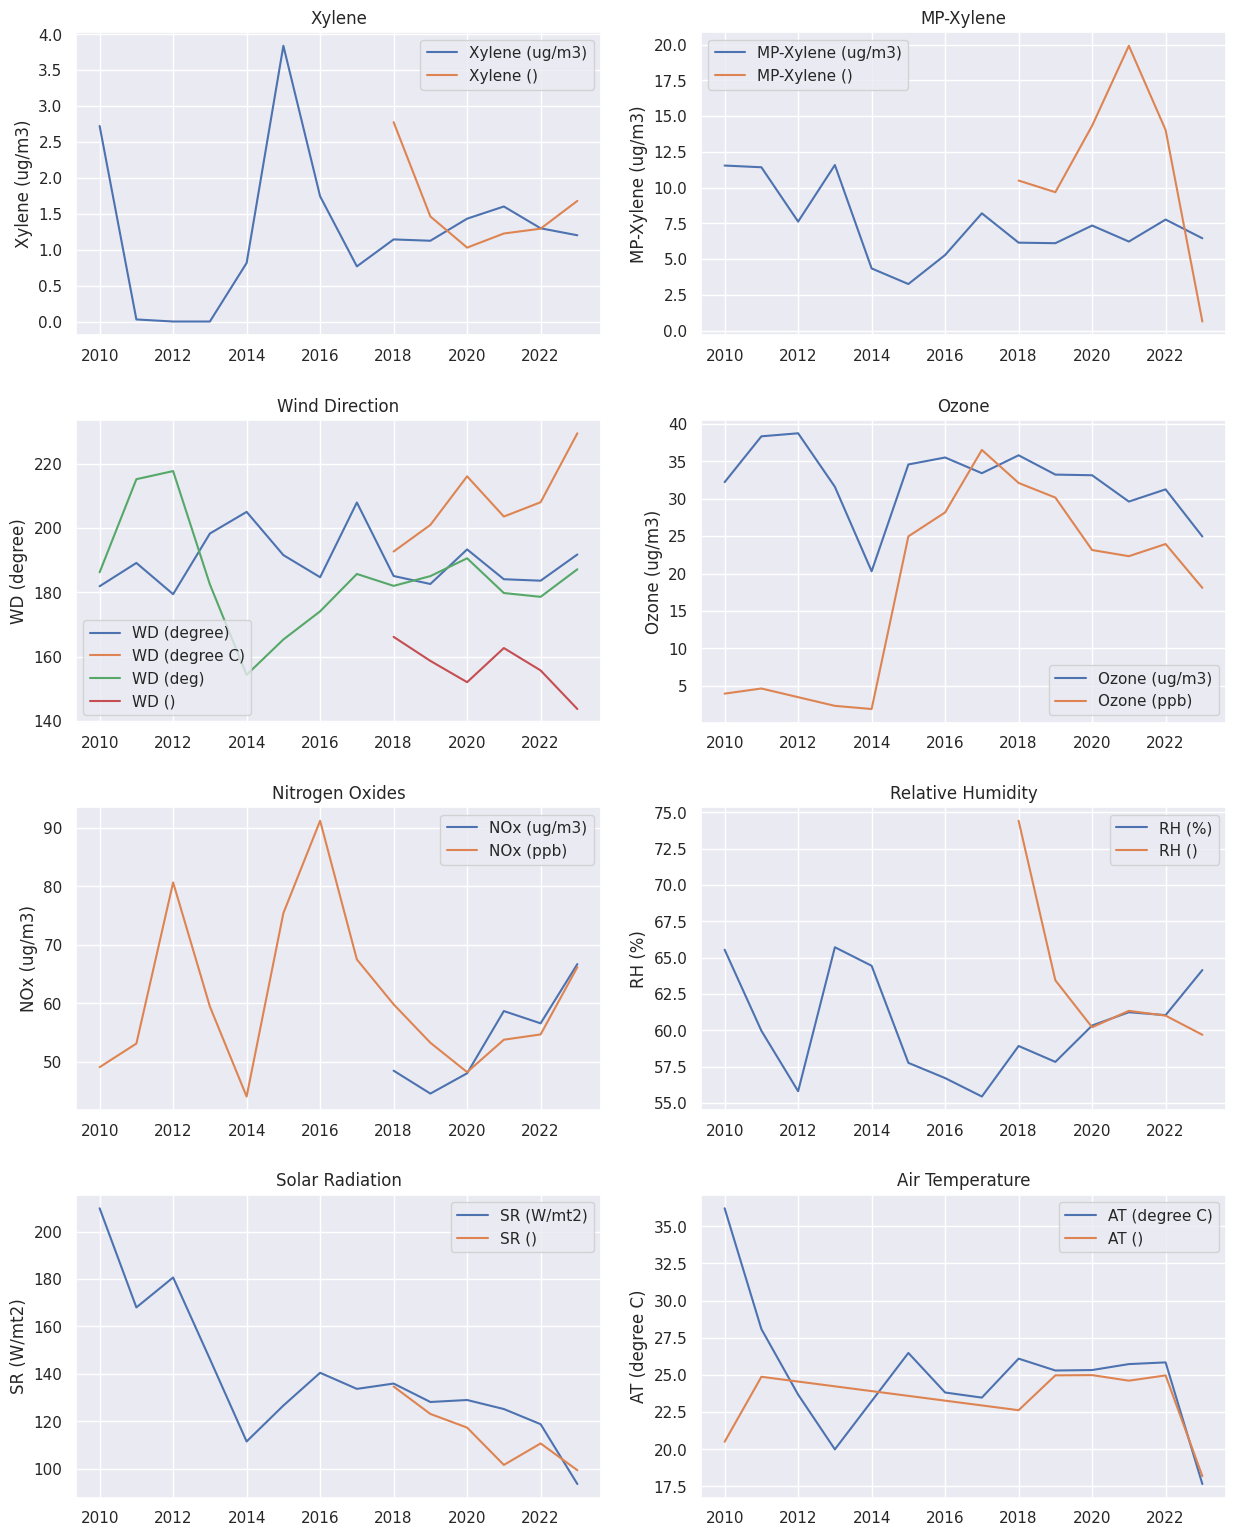

In [10]:
groups = {
    'Xylene':            ['Xylene (ug/m3)', 'Xylene ()'],
    "MP-Xylene":         ['MP-Xylene (ug/m3)', 'MP-Xylene ()'],
    'Wind Direction':    ["WD (degree)", "WD (degree C)", "WD (deg)", "WD ()"],
    'Ozone':             ['Ozone (ug/m3)', 'Ozone (ppb)'],
    'Nitrogen Oxides':   ['NOx (ug/m3)', 'NOx (ppb)'],
    'Relative Humidity': ['RH (%)', 'RH ()'],
    'Solar Radiation':   ['SR (W/mt2)', 'SR ()'],
    'Air Temperature':   ['AT (degree C)', 'AT ()']
}

f_similarities(df, groups, columns=2)

In [11]:
# Flatten the list of lists into a single list of feature names from the 'groups' dictionary
# This is done by iterating over each sublist (group.values()) and each item within those sublists
groups = [item for sublist in list(groups.values()) for item in sublist]

# Select columns from the DataFrame that match the feature names in the 'groups' list
# and calculate descriptive statistics for these features
DATA_STATS = df[groups].describe()

# Apply formatting to the descriptive statistics to round them to 3 decimal places
# This makes the output more readable and concise
formatted_stats = DATA_STATS.applymap(lambda x: f"{x:0.3f}")

# The result is a DataFrame of descriptive statistics for the features of interest,
# where each statistic is formatted as a string with 3 decimal places
formatted_stats

,Xylene (ug/m3),Xylene (),MP-Xylene (ug/m3),MP-Xylene (),WD (degree),WD (degree C),WD (deg),WD (),Ozone (ug/m3),Ozone (ppb),NOx (ug/m3),NOx (ppb),RH (%),RH (),SR (W/mt2),SR (),AT (degree C),AT ()
count,242944.000,34578.000,264768.000,29205.000,813361.000,43888.000,655812.000,122463.000,1874697.000,47576.000,86086.000,1876466.000,1611483.000,39722.000,1555347.000,43267.000,1110834.000,83016.000
mean,1.337,1.319,7.040,13.824,186.417,205.871,184.905,157.480,32.370,25.864,52.076,56.894,59.893,62.812,130.106,116.041,25.136,24.178
std,5.762,3.348,13.603,19.986,94.905,88.418,80.286,91.992,34.778,19.535,59.768,70.730,22.548,20.497,180.273,172.197,8.561,8.426
min,0.000,0.000,0.010,0.010,0.020,1.200,0.030,1.300,0.010,0.050,0.100,0.000,0.010,0.820,0.000,2.720,0.100,1.880
25%,0.000,0.000,1.210,2.890,104.850,119.570,121.010,86.950,8.550,13.530,17.380,16.980,43.120,46.450,5.580,3.480,18.580,17.420
50%,0.000,0.400,2.940,7.040,187.380,230.435,185.310,147.830,19.600,20.480,31.050,31.680,61.330,63.820,29.500,11.350,26.400,25.380
75%,1.010,1.400,7.410,15.760,268.950,285.550,252.050,229.700,43.150,33.130,61.100,64.280,78.000,80.000,216.210,174.735,31.500,30.300
max,476.310,231.000,491.510,286.010,360.000,356.520,359.590,359.700,200.000,198.470,498.850,500.000,100.000,99.200,1995.000,836.420,58.900,56.270


I was able to merge the following features. The rest have too many missing values so we are going to drop them.

In [12]:
reduction_groups = {
    "Xylene (ug/m3)":    ["Xylene ()"],
    "MP-Xylene (ug/m3)": ["MP-Xylene ()"],
    "Benzene (ug/m3)":   ["Benzene ()"],
    "Toluene (ug/m3)":   ["Toluene ()"],
    "SO2 (ug/m3)":       ["SO2 ()"],
    "NOx (ug/m3)":       ["NOx (ppb)"],
    "Ozone (ug/m3)":     ["Ozone (ppb)"],
    "AT (degree C)":     ["AT ()"],
    "WD (degree)":       ["WD (degree C)", "WD (deg)", "WD ()"],
    "WS (m/s)":          ["WS ()"]
}

In [13]:
def merge(dataframe, columns):
    '''
    Merges multiple columns into a single column within the provided DataFrame.
    This is particularly useful when you have multiple columns representing the same data type
    and want to consolidate them into a single column for cleaner data or analysis.

    Parameters
    ----------
    dataframe (DataFrame): The DataFrame to edit.
    columns (dict): A dictionary where the key is the name of the column to merge records into,
                    and the value is a list of column names whose records are to be merged.

    Returns
    -------
    DataFrame: The modified DataFrame with the specified columns merged.
    '''

    # Iterate through each item in the dictionary to merge columns
    for column, cols_to_merge in columns.items():
        # Check if the target column exists in the DataFrame; if not, create it with NaN values.
        # This check is important to ensure that the target column is ready to receive merged data.
        if column not in dataframe.columns and any(name in dataframe.columns for name in cols_to_merge):
            dataframe[column] = np.nan

        # Iterate through each column name intended to be merged into the target column.
        for col_name in cols_to_merge:
            # If the column to merge exists in the DataFrame,
            # then proceed to fill the target column's NaN values with values from this column.
            if col_name in dataframe.columns:
                dataframe[column] = dataframe[column].fillna(dataframe[col_name])
                # After merging the data from the current column into the target column,
                # drop the current column as it's no longer needed.
                dataframe = dataframe.drop(columns=[col_name])

    # Return the modified DataFrame with the merged columns.
    return dataframe

In [14]:
df = merge(df, reduction_groups)

### Missing Values


In [15]:
#Checking Missing Values
df.isnull().sum().sort_values(ascending=False)

NMHC (ug/m3)           2796171
Eth-Benzene ()         2796171
SPM (ug/m3)            2796171
Gust (m/s)             2796171
Gust (km/hr)           2796171
CO2 (mg/m3)            2796171
Temp (ug/m3)           2796171
Power (W)              2796171
Variance (n)           2796171
Gust (kl/h)            2796171
CH4 ()                 2785343
HCHO (ug/m3)           2762343
Hg (ug/m3)             2761020
MH (m)                 2758723
BP ()                  2756663
RH ()                  2756449
SR ()                  2752904
CO (ng/m3)             2752432
CH4 (ug/m3)            2734776
THC (ug/m3)            2733520
CO (ug/m3)             2712197
O Xylene (ug/m3)       2611212
Eth-Benzene (ug/m3)    2568923
Xylene (ug/m3)         2518649
MP-Xylene (ug/m3)      2502198
VWS (m/s)              2370506
Temp (degree C)        2295873
RF (mm)                1899980
AT (degree C)          1602321
BP (mmHg)              1417134
NH3 (ug/m3)            1366814
Toluene (ug/m3)        1313863
Benzene 

In [16]:
#Dropping Missing Values
df = df.dropna(how='all')
df = df.dropna(how='all', axis='columns')

In [17]:
def GET_NULL_ENTRIES(dataframe):

    # Calculate the total number of null values for each column in the DataFrame
    null_vals = dataframe.isnull().sum()

    # Create a new DataFrame that combines the null counts with the percentage of null values for each column
    # The percentage is calculated as the number of nulls divided by the total length of the DataFrame, then rounded to 2 decimal places
    df_null_vals = pd.concat({
        'Null Count': null_vals,
        'Percent Missing (%)': round(null_vals * 100 / len(dataframe), 2)
    }, axis=1)

    # Return the DataFrame sorted by the 'Null Count' column in descending order
    # This helps in quickly identifying which columns have the most missing values
    return df_null_vals.sort_values(by=['Null Count'], ascending=False)

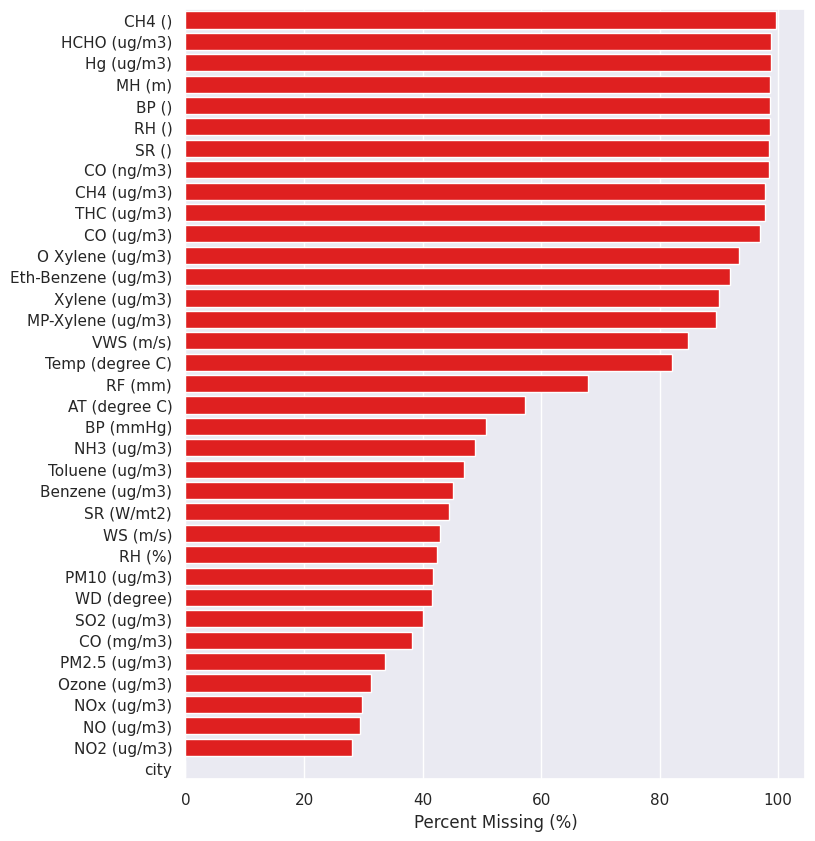

In [18]:
df_null_info = GET_NULL_ENTRIES(df)

plt.figure(figsize=(8, 10))
sns.barplot(data=df_null_info, x='Percent Missing (%)', y=df_null_info.index, orient='h', color='red')
plt.show()

#### Dataset's Null Count Information


In [19]:
# Start by identifying all unique states present in the 'df_states' DataFrame.
unique_states = df_states['state'].unique()
unique_states

# Define a function to get a comprehensive overview of missing data across all states.
def GET_TOTAL_INFO():
    # Initialize a dictionary to keep track of feature-wise null counts.
    features = {}
    # Initialize a counter to keep track of the total number of records processed.
    total_records = 0

    # Loop through each state to process its data.
    for i, state_name in enumerate(unique_states):
        # Clear any previous output to keep the display tidy and show progress.
        clear_output(wait=False)
        print(f"Processing state of {state_name} ({i+1}/{len(unique_states)})")

        # Combine data for the current state and set up its structure.
        temp_df = STATE_DATA_COMB(state_name)  # Combine data from multiple files for the state.
        temp_df = df_index(temp_df)             # Set 'From Date' as the index for time series analysis.
        temp_df = temp_df.dropna(how='all')     # Get rid of any rows where all elements are missing.

        # Get a summary of null values for the current state's data.
        comparisons = GET_NULL_ENTRIES(temp_df)

        # Update the total record count.
        total_records += df.shape[0]

        # Update the feature-wise null count based on current state's data.
        for feature in comparisons.index:
            # If the feature is already in the dictionary, increment its count; otherwise, add it to the dictionary.
            if feature in features:
                features[feature] += comparisons.loc[[feature]]['Null Count'].values[0]
            else:
                features[feature] = comparisons.loc[[feature]]['Null Count'].values[0]

    # Convert the feature-wise null count dictionary into a DataFrame for better readability.
    ds_null_info = pd.DataFrame.from_dict(features, orient='index', columns=['Null Count'])
    # Calculate the percentage of missing values for each feature.
    ds_null_info['Percent Missing (%)'] = round(ds_null_info['Null Count'] * 100 / total_records, 2)
    # Sort the data by the number of missing values so the most problematic features are at the top.
    ds_null_info = ds_null_info.sort_values(by=['Null Count'], ascending=False)

    # Return the comprehensive null information DataFrame.
    return ds_null_info

Processing state of West Bengal (31/31)
Combining a total of 14 files...



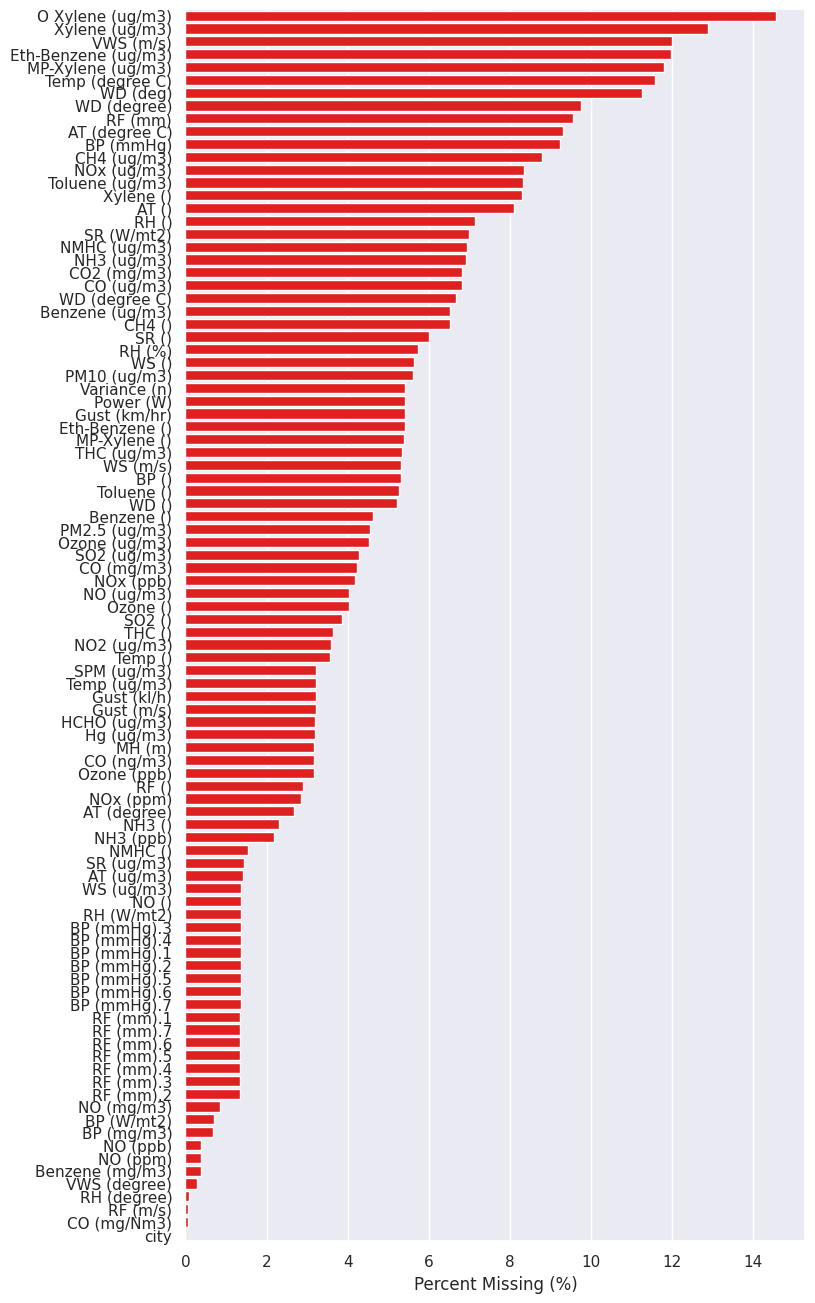

In [20]:
overall_ds_info = GET_TOTAL_INFO()

plt.figure(figsize=(8, 16))
sns.barplot(data=overall_ds_info, x='Percent Missing (%)', y=overall_ds_info.index, orient='h', color='red')
plt.show()

In [21]:
# Dropping the value using Threshold.
threshold = 0.6
df = df.dropna(thresh=df.shape[0]*threshold, axis=1)

In [22]:
GET_NULL_ENTRIES(df)

,Null Count,Percent Missing (%)
CO (mg/m3),1070972,38.30
PM2.5 (ug/m3),939895,33.61
Ozone (ug/m3),873898,31.25
NOx (ug/m3),833619,29.81
NO (ug/m3),821483,29.38
NO2 (ug/m3),783452,28.02
city,0,0.00


## Exploratory Data Analysis (EDA)

In [23]:
pollutants = {
    'Particulate Matter' : ['PM2.5 (ug/m3)', 'PM10 (ug/m3)'],

    'Nitrogen Compounds' : ['NOx (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NH3 (ug/m3)'],

    'Hydrocarbons' : ['Benzene (ug/m3)', 'Eth-Benzene (ug/m3)', 'Xylene (ug/m3)', 'MP-Xylene (ug/m3)', 'O Xylene (ug/m3)', 'Toluene (ug/m3)'],

    'Carbon Monoxide': ['CO (mg/m3)'],

    'Sulfur Dioxide': ['SO2 (ug/m3)'],

    'Ozone Concentration' : ['Ozone (ug/m3)']
}

other_metrics = {

    'Solar Radiation' : ['SR (W/mt2)'],

    'Temperatures' : ['Temp (degree C)', 'AT (degree C)'],

    'Relative Humidity' : ['RH (%)'],

    'Rainfall' : ['RF (mm)'],

    'Barometric Pressure' : ['BP (mmHg)'],

    'Wind Direction' : ['WD (degree)'],

    'Wind Speed' : ['WS (m/s)']
}


In [24]:
slice_groups = {
    'Group by Day':   df.groupby(pd.Grouper(freq='1D')).mean(numeric_only=True),
    'Group by Month': df.groupby(pd.Grouper(freq='1M')).mean(numeric_only=True),
    'Group by Year':  df.groupby(pd.Grouper(freq='1Y')).mean(numeric_only=True)
}

In [25]:
def FEATURE_PLOT(features, slice_groups):
    for feature in features:
        fig, ax = plt.subplots(1, 1, figsize=(12, 4))
        fig.suptitle(feature)

        labels = []
        for i, (group, group_df) in enumerate(slice_groups.items()):
            data_slice = group_df[group_df.columns.intersection(pollutants[feature])]

            # Keep only the NOx feature, as it combines both NO (Nitrogen Oxide) and NO2 (Nitrogen Dioxide)
            if feature == "Nitrogen Compounds":
                data_slice = data_slice.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1)

            data_slice.plot(kind="line", ax=ax)

            for column in data_slice.columns:
                labels.append(f'{column} [{group}]')

        ax.set(xlabel=None)
        ax.legend(labels)
        plt.plot()

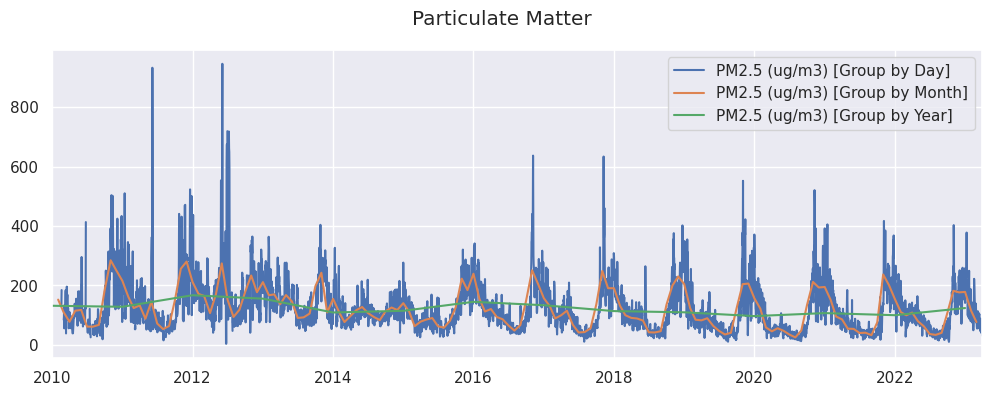

In [26]:
features_to_plot = ['Particulate Matter']
FEATURE_PLOT(features_to_plot, slice_groups)

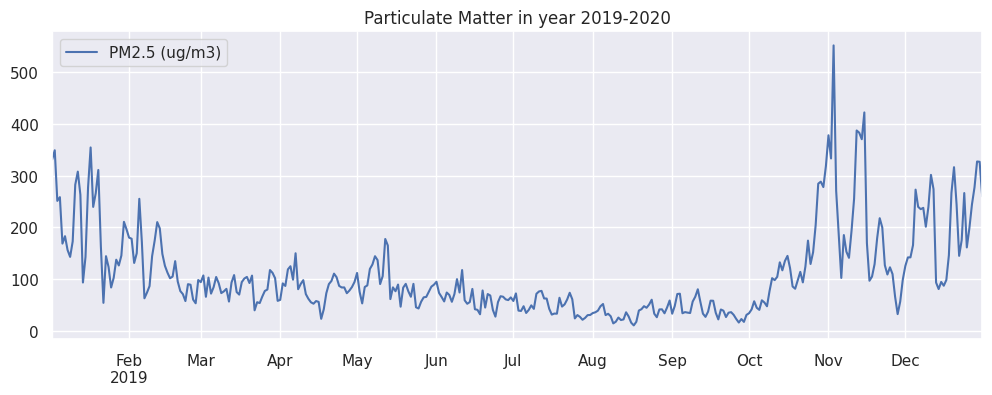

In [27]:
for feature in features_to_plot:
    data_slice = slice_groups['Group by Day'][slice_groups['Group by Day'].columns.intersection(pollutants[feature])]
    data_slice.query('datetime > 2019 and datetime < 2020').plot(title=f'{feature} in year 2019-2020', figsize=(12,4)).set(xlabel=None)

### Correlation Matrix
Tovisualise the correlation between features

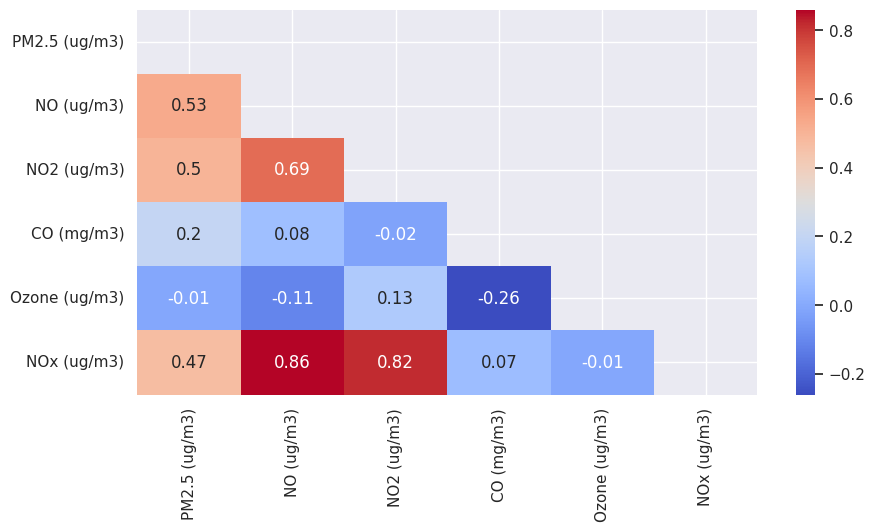

In [28]:
# Calculate the correlation matrix for the 'Group by Day' data from the slice_groups.
corr = slice_groups['Group by Day'].corr(numeric_only=True).round(2)

# Create a mask for the upper triangle of the matrix to avoid displaying redundant information.
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the figure for the heatmap with a specific size for good visibility.
plt.figure(figsize=(10,5))

# Generate the heatmap using seaborn. The 'coolwarm' colormap is used here for better visual contrast.
# 'annot=True' displays the correlation coefficients on the heatmap for precision.
# The mask hides the upper triangle of the matrix, keeping the plot clean and readable.
sns.heatmap(data=corr, mask=mask, annot=True, cmap="coolwarm")
plt.show()

In [29]:
corr_target = abs(corr['PM2.5 (ug/m3)'])
relevant_features = corr_target[corr_target>0.4]
relevant_features.sort_values(ascending=False)

PM2.5 (ug/m3)    1.00
NO (ug/m3)       0.53
NO2 (ug/m3)      0.50
NOx (ug/m3)      0.47
Name: PM2.5 (ug/m3), dtype: float64

In [30]:
df = df.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1)

### Resampling

In [31]:
df = df.resample('60min').mean(numeric_only=True)

### Outlier Detection and Removal


<Axes: xlabel='datetime'>

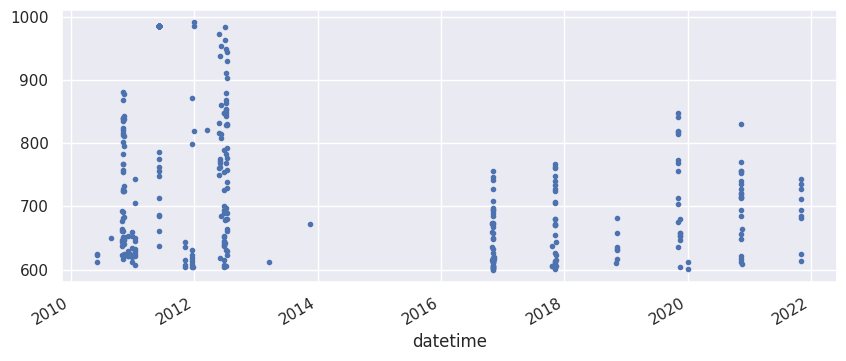

In [32]:
df.query('`PM2.5 (ug/m3)` > 600')['PM2.5 (ug/m3)'].plot(style='.', figsize=(10,4))

In [33]:
df['PM2.5 (ug/m3)'] = df['PM2.5 (ug/m3)'].mask(df['PM2.5 (ug/m3)'].gt(950))

<Axes: xlabel='datetime'>

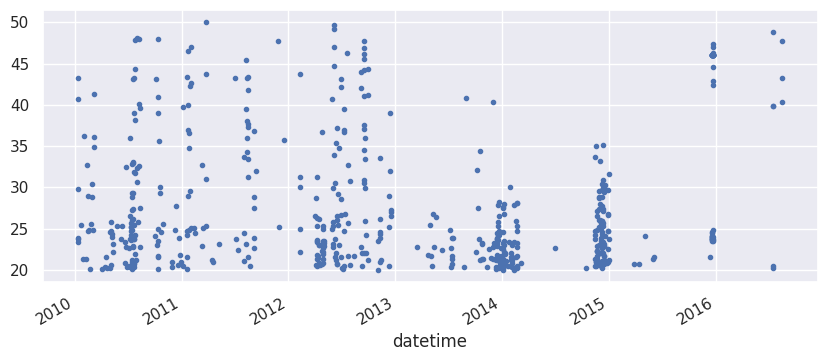

In [34]:
df.query('`CO (mg/m3)` > 20')['CO (mg/m3)'].plot(style='.', figsize=(10,4))

In [35]:
df['CO (mg/m3)'] = df['CO (mg/m3)'].mask(((df.index > '2015') & df['CO (mg/m3)'].gt(35)))

<Axes: xlabel='datetime'>

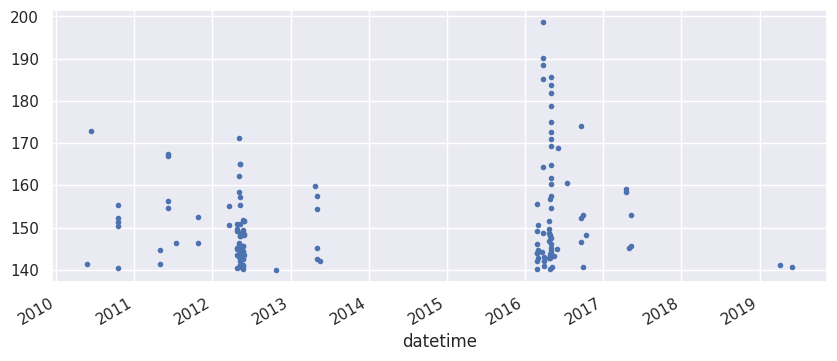

In [36]:
df.query('`Ozone (ug/m3)` > 140')['Ozone (ug/m3)'].plot(style='.', figsize=(10,4))

In [37]:
df['Ozone (ug/m3)'] = df['Ozone (ug/m3)'].mask(df['Ozone (ug/m3)'].gt(185))

<Axes: xlabel='datetime'>

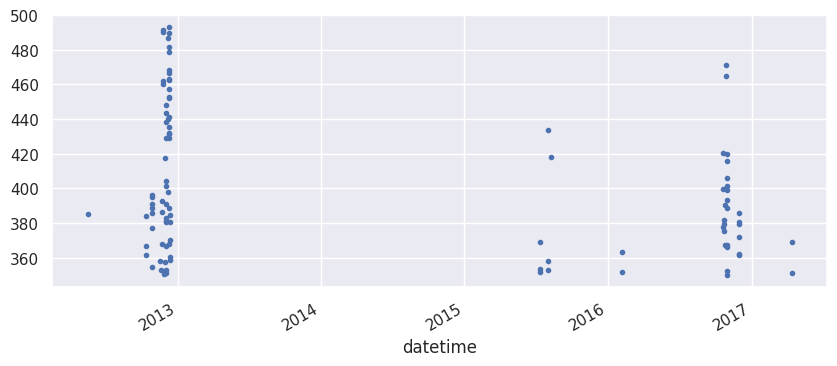

In [38]:
df.query('`NOx (ug/m3)` > 350')['NOx (ug/m3)'].plot(style='.', figsize=(10,4))

In [39]:
# Updating the 'NOx (ug/m3)' column in the DataFrame to address outliers based on specific conditions.
df['NOx (ug/m3)'] = df['NOx (ug/m3)'].mask((
    # The first condition targets data before the year 2013 where 'NOx (ug/m3)' values are greater than 380.
    # It's suggesting that before 2013, any reading above 380 might be an outlier or an error.
    ((df.index < '2013') & (df['NOx (ug/m3)'].gt(380))) |

    # The second condition targets the specific period between 2015 and 2016 where 'NOx (ug/m3)' values are greater than 400.
    # Perhaps there was a known issue or event during this period that caused abnormally high readings.
    ((df.index > '2015') & (df.index < '2016') & (df['NOx (ug/m3)'].gt(400))) |

    # The third condition targets data after 2016 where 'NOx (ug/m3)' values are greater than 450.
    # This might be due to a new standard or understanding that readings above 450 are not plausible after 2016.
    ((df.index > '2016') & (df['NOx (ug/m3)'].gt(450)))
))


### Handling Missing Values

In [40]:
GET_NULL_ENTRIES(df)

,Null Count,Percent Missing (%)
PM2.5 (ug/m3),3908,3.37
CO (mg/m3),2123,1.83
NOx (ug/m3),104,0.09
Ozone (ug/m3),67,0.06


In [41]:
#Using Interpolation
df = df.interpolate(method='pad')
df = df.fillna(df.mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116112 entries, 2010-01-01 00:00:00 to 2023-03-31 23:00:00
Freq: 60T
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   PM2.5 (ug/m3)  116112 non-null  float64
 1   CO (mg/m3)     116112 non-null  float64
 2   Ozone (ug/m3)  116112 non-null  float64
 3   NOx (ug/m3)    116112 non-null  float64
dtypes: float64(4)
memory usage: 4.4 MB


In [42]:
def FEATURE_CREATION(df):
    df = df.copy()
    df['hour']       = df.index.hour
    df['dayofmonth'] = df.index.day
    df['dayofweek']  = df.index.dayofweek
    df['dayofyear']  = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype("int64")
    df['month']      = df.index.month
    df['quarter']    = df.index.quarter
    df['year']       = df.index.year
    return df

In [43]:
date_features = ['hour', 'dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year']
df = FEATURE_CREATION(df)

In [44]:
# Lag features are a common statistical technique used in time series forecasting to help the model understand patterns over time.
def FORECAST_FEATURE_CREATION(df):
    # Create a copy of the DataFrame to avoid modifying the original data.
    df = df.copy()

    # Create a new column 'pm_lag_1Y' to represent the lagged feature for 1 year.
    # This is done by shifting the 'PM2.5 (ug/m3)' values 365 days times 24 hours back.
    # It means that for a given hour, 'pm_lag_1Y' will show the 'PM2.5 (ug/m3)' value from exactly one year before.
    df['pm_lag_1Y'] = df['PM2.5 (ug/m3)'].shift(365*24)   # 1 year lag

    # Similarly, create another new column 'pm_lag_2Y' for a 2-year lag.
    # This column will show the 'PM2.5 (ug/m3)' value from exactly two years before the current hour.
    df['pm_lag_2Y'] = df['PM2.5 (ug/m3)'].shift(730*24)   # 2 year lag

    return df

In [45]:
lag_features = ['pm_lag_1Y', 'pm_lag_2Y']
df = FORECAST_FEATURE_CREATION(df)
df.head()

,PM2.5 (ug/m3),CO (mg/m3),Ozone (ug/m3),NOx (ug/m3),hour,dayofmonth,dayofweek,dayofyear,weekofyear,month,quarter,year,pm_lag_1Y,pm_lag_2Y
datetime,,,,,,,,,,,,,,
2010-01-01 00:00:00,123.404029,2.340000,26.0650,73.7425,0,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 01:00:00,123.404029,2.327500,20.3425,36.0000,1,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 02:00:00,123.404029,2.177500,11.0650,27.1900,2,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 03:00:00,123.404029,1.992500,18.4625,21.1125,3,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 04:00:00,123.404029,2.096667,13.7500,23.1550,4,1,4,1,53,1,1,2010,NaN,NaN


In [46]:
def RELACE_NULL_DATA(df, how):
    '''
    This function is all about tidying up your data by dealing with those pesky missing values (NaNs) in lag features.
    Depending on your needs and the nature of your data, you might want to fill those gaps with zeros or just get rid of them altogether.

    Parameters:
      df (DataFrame): The data you're working with. It's got some missing values you want to deal with.
      how (str): This tells the function how you'd like to handle those missing values. You've got options!
          - 'zeros': This will replace all NaNs with zeros. It's like saying, "Where I don't have data, just assume it's zero."
          - 'drop': This will remove any row that's got at least one NaN. It's more of a clean slate approach.

    Returns:
      DataFrame: Your original data, but cleaned up according to your 'how' parameter.
    '''

    # If you decided to fill missing values with zeros:
    if how == 'zeros':
        # Replace all NaNs with 0 and return the modified DataFrame.
        return df.fillna(0)

    # If you decided to drop rows with missing values:
    if how == 'drop':
        # Remove all rows that have at least one NaN and return the result.
        return df.dropna(how='any')

##  Data Preparation for Time Series Forecasting

In [47]:
target = 'PM2.5 (ug/m3)'
predictors = date_features + lag_features

In [48]:
def create_train_test_sets(dataframe, split, replace_na=False, method='none'):
    """
    Splits the data into training and testing sets and applies optional cleaning to handle missing values.

    """

    # Create a copy of the input DataFrame to avoid modifying the original data.
    dataframe = dataframe.copy()

    # If requested, replace missing values using the specified method.
    if replace_na:
        dataframe = RELACE_NULL_DATA(dataframe, how=method)

    # Calculate the index to split the data at and then split the DataFrame into training and testing sets.
    train_set, test_set = np.split(dataframe, [int(len(dataframe) * split)])

    # Split the features (predictors) and the target variable for both training and testing sets.
    # 'predictors' and 'target' need to be defined outside this function.
    return train_set[predictors], test_set[predictors], train_set[target], test_set[target]

In [49]:
X_train, X_test, y_train, y_test = create_train_test_sets(df, split=0.8, replace_na=True, method='drop')

### Ensemble Methods

In [50]:
ensemble_models = {
    'Random Forest':     RandomForestRegressor(random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingRegressor(random_state=RANDOM_STATE),
    'AdaBoost':          AdaBoostRegressor(random_state=RANDOM_STATE),
    'Histogram GB':      HistGradientBoostingRegressor(random_state=RANDOM_STATE),
    'XGBoost':           xgb.XGBRegressor(random_state=RANDOM_STATE)
}

In [51]:
def model_scores(models):
    '''
    Evaluates multiple models on the training and testing sets using various performance metrics.
    '''

    # Initialize an empty list to store performance metrics for each model.
    scores = []

    # Loop through each model in the dictionary.
    for model_name, model in models.items():
        # Fit the model on the training data.
        model.fit(X_train, y_train)
        # Use the fitted model to make predictions on the test set.
        predictions_test = model.predict(X_test)

        # Calculate various performance metrics for the model and append them to the metrics list.
        # These metrics include R-squared for training and test sets, Root Mean Squared Error (RMSE),
        # Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE).
        scores.append([
            model_name,  # The name of the model.
            model.score(X_train, y_train),  # R-squared value for the training set.
            r2_score(y_test, predictions_test),  # R-squared value for the testing set.
            np.sqrt(mean_squared_error(y_test, predictions_test)),  # RMSE for the testing set.
            mean_absolute_error(y_test, predictions_test),  # MAE for the testing set.
            mean_absolute_percentage_error(y_test, predictions_test)  # MAPE for the testing set.
        ])

    # Convert the list of metrics into a DataFrame for better readability and return it.
    # The DataFrame will have columns for the model name, R-squared on training data, R-squared on test data,
    # RMSE, MAE, and MAPE, providing a comprehensive view of each model's performance.
    return pd.DataFrame(scores, columns=['model', 'r2_train', 'r2_test', 'rmse', 'mae', 'mape'])


In [52]:
estimator_scores = model_scores(ensemble_models)

In [53]:
def plot_rmse(scores):
    # Create a bar plot for RMSE
    plt.figure(figsize=(8, 6))
    sns.barplot(data=scores[['model', 'rmse']].round(2), x='rmse', y='model', orient='h')

    plt.title('Root Mean Squared Error')
    plt.xlabel('RMSE')
    plt.ylabel('Model')
    plt.xlim(0, max(scores['rmse']) + 12)

    plt.show()

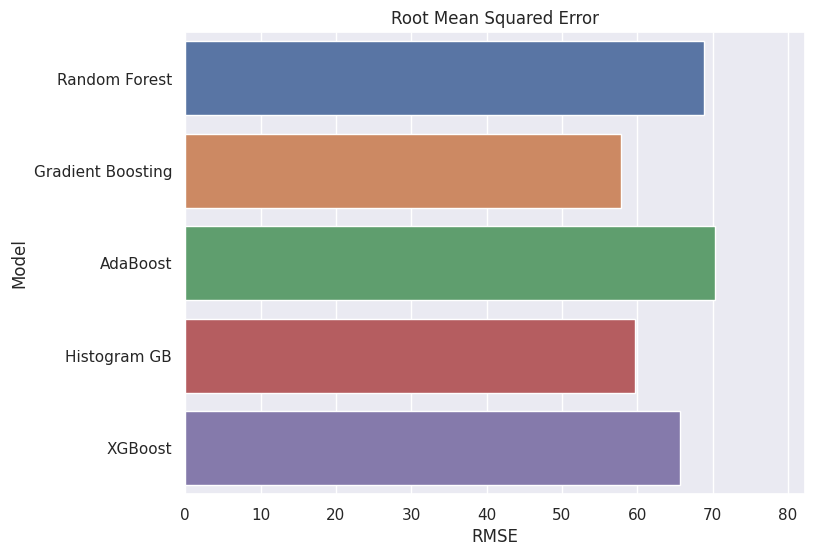

In [54]:
plot_rmse(estimator_scores)

#### Cross-Validation


In [55]:
cv = TimeSeriesSplit(n_splits=5) #Splitting the data into 5 splits

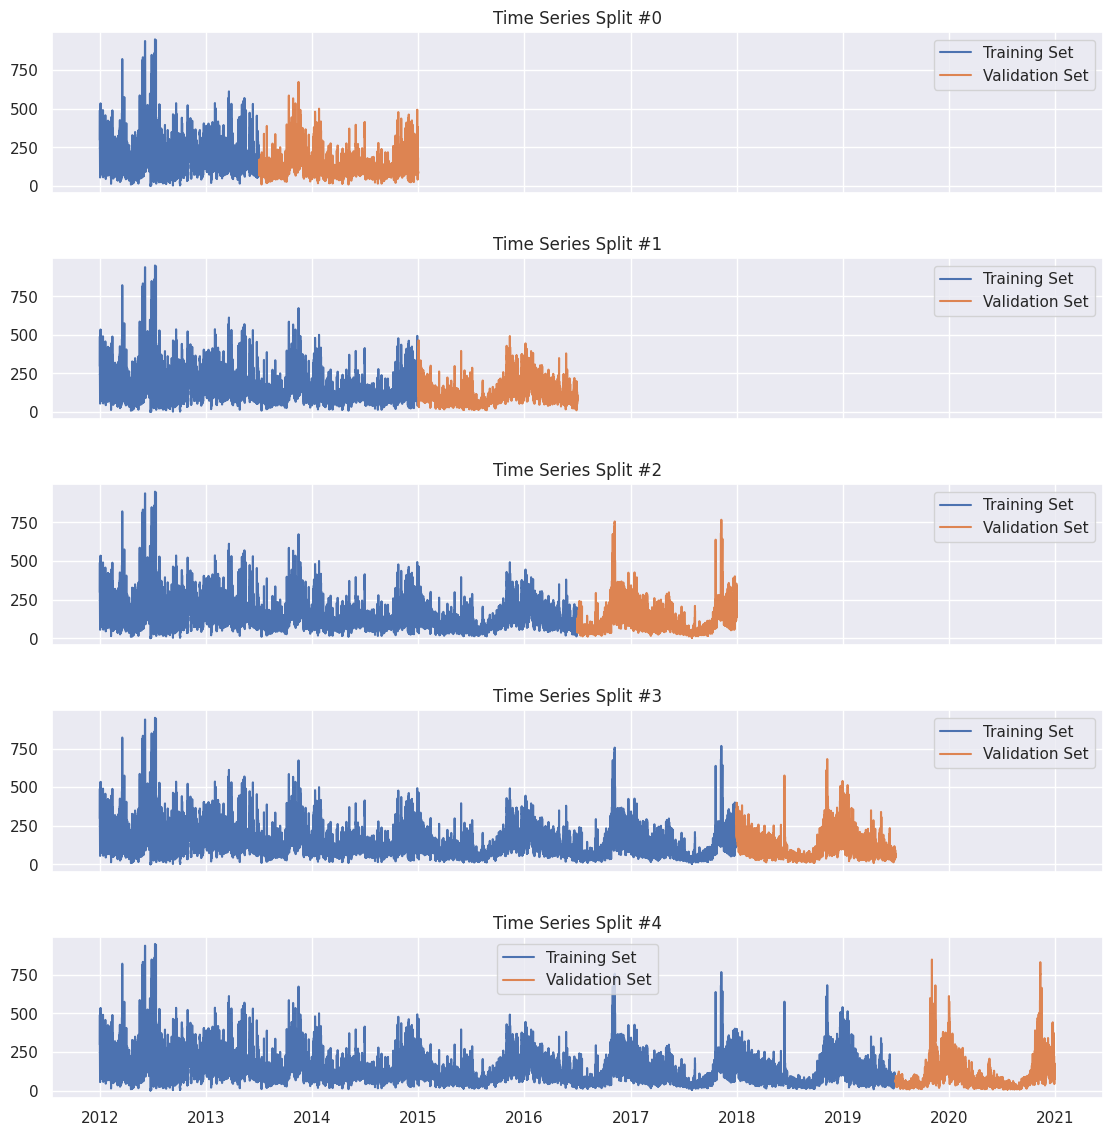

In [56]:
fig, axes = plt.subplots(cv.n_splits, 1, figsize=(12, 12), sharex=True)
fig.tight_layout(pad=3.0)

for index, (train_fold, validation_fold) in enumerate(cv.split(y_train)):
    sns.lineplot(data=y_train.iloc[train_fold], label='Training Set', ax=axes[index])
    sns.lineplot(data=y_train.iloc[validation_fold], label='Validation Set', ax=axes[index])
    axes[index].set_title(f'Time Series Split #{index}')
    axes[index].set(xlabel=None, ylabel=None)

plt.show()

In [57]:
def cross_val_scores(models, x, y, cv, scoring):
    '''
    Getting cross validated scores for input models.
    '''

    total = [(model_name, i, score)
                    for model_name, model in ensemble_models.items()
                    for i, score in enumerate(-cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=CORE))]

    results = pd.DataFrame(total, columns=['model', 'fold', 'score'])
    return results

In [58]:
cv_results = cross_val_scores(ensemble_models, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')

In [59]:
cv_results.groupby('model').score.mean().sort_values()

model
Histogram GB         69.701545
Gradient Boosting    69.793608
XGBoost              74.470002
Random Forest        75.436674
AdaBoost             80.973730
Name: score, dtype: float64

#### Hyperparameter Tuning
We will be using RandomizedSearch for it

In [60]:
#Getting the optimal parameters
MODEL_OPTIMAL = {
    'Random Forest': {'n_estimators': [100,150,200],
                      'min_samples_split': [2,5],
                      'min_samples_leaf': [2,4,10],
                      'max_depth': [5,10],
                      'n_jobs': [CORE],
                      'random_state': [RANDOM_STATE]},

    'Gradient Boosting': {'learning_rate': np.arange(0.01,1,0.01),
                          'n_estimators': [100,200,300],
                          'min_samples_split': [2,5],
                          'min_samples_leaf': [1,4,10],
                          'max_depth': [3,5],
                          'n_iter_no_change': [10],
                          'tol': [0.01],
                          'random_state': [RANDOM_STATE]},

    'AdaBoost': {'learning_rate': np.arange(0.01,1,0.01),
                 'n_estimators': [50,100,200,300],
                 'random_state': [RANDOM_STATE]},

    'Histogram GB': {'learning_rate': np.arange(0.01,1,0.01),
                     'max_iter': [100,150,200],
                     'min_samples_leaf': [10,20,30],
                     'max_depth': [None,3,5,10],
                     'n_iter_no_change': [10],
                     'tol': [0.01],
                     'random_state': [RANDOM_STATE]},

    'XGBoost': {'learning_rate': np.arange(0.01,1,0.01),
                'n_estimators': [20,50,100,250],
                'max_depth': [None,3,5],
                'eval_metric': ['rmse'],
                'early_stopping_rounds': [10],
                'n_jobs': [CORE],
                'random_state': [RANDOM_STATE]}
}

In [61]:
def RANDOM_CROSS_SEARCH(models, params, n_iter, cv, scoring):
    '''
    Performs hyperparameter tuning using RandomizedSearch.

    '''

    print(f'Fitting {cv.n_splits} folds for each of {n_iter} candidates, totalling {cv.n_splits*n_iter} fits.\n')

    model_scores = []

    for model_name, model in ensemble_models.items():
        start = time.time()

        # Use RandomizedSearch as the search space is quite big. For more accurate results we can use GridSearch.
        rscv_model = RandomizedSearchCV(model, params[model_name],
                                        cv=cv,
                                        scoring=scoring,
                                        return_train_score=True,
                                        n_jobs=CORE,
                                        n_iter=n_iter,
                                        random_state=RANDOM_STATE)

        if model_name == 'XGBoost':
            rscv_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)
        else:
            rscv_model.fit(X_train, y_train)
        end = time.time()

        print(f'Randomized Search CV for {model_name} finished after {round(end-start, 2)} seconds. Best parameters found:')
        print(f'{rscv_model.best_params_}\n')

        models[model_name] = rscv_model.best_estimator_
        model_scores.append((model_name, round(-rscv_model.best_score_, 4)))

    model_scores = pd.DataFrame(model_scores, columns=['model', 'score'])

    return models, model_scores

In [63]:
ensemble_models, rscv_scores = RANDOM_CROSS_SEARCH(ensemble_models, MODEL_OPTIMAL, n_iter=5, cv=cv, scoring="neg_root_mean_squared_error")

Fitting 5 folds for each of 5 candidates, totalling 25 fits.

Randomized Search CV for Random Forest finished after 301.88 seconds. Best parameters found:
{'random_state': 18, 'n_jobs': -1, 'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5}

Randomized Search CV for Gradient Boosting finished after 388.46 seconds. Best parameters found:
{'tol': 0.01, 'random_state': 18, 'n_iter_no_change': 10, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.08}

Randomized Search CV for AdaBoost finished after 109.25 seconds. Best parameters found:
{'random_state': 18, 'n_estimators': 300, 'learning_rate': 0.12}

Randomized Search CV for Histogram GB finished after 23.84 seconds. Best parameters found:
{'tol': 0.01, 'random_state': 18, 'n_iter_no_change': 10, 'min_samples_leaf': 30, 'max_iter': 150, 'max_depth': 5, 'learning_rate': 0.08}

Randomized Search CV for XGBoost finished after 12.22 seconds. Best parameters

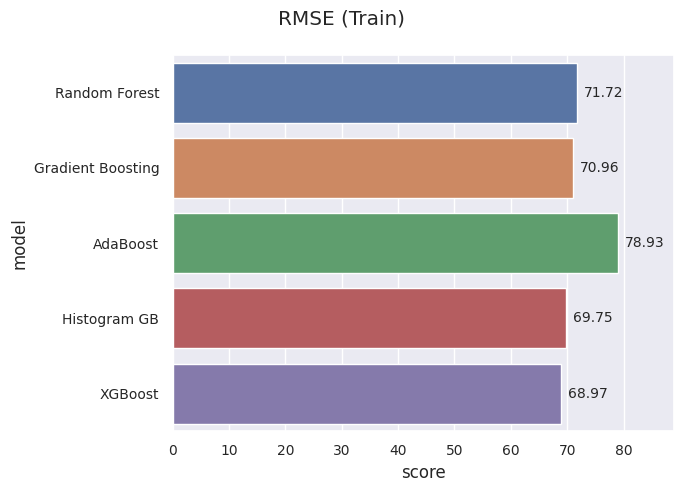

In [64]:
fig = plt.figure(figsize=(7,5))
fig.suptitle("RMSE (Train)")

metrics_plt = sns.barplot(rscv_scores.round(2), x='score', y='model', orient='h')
metrics_plt.tick_params(labelsize=10)
metrics_plt.bar_label(metrics_plt.containers[0], size=10, padding=5)

plt.xlim(0, max(rscv_scores.score)+10)
plt.tight_layout()
plt.show()

Measuring prediction and training time of models

In [65]:
time_metrics = []
for model_name, model in ensemble_models.items():

    fit_start = time.time()
    if model_name == 'XGBoost':
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)
    else:
        model.fit(X_train, y_train)
    fit_end = time.time()

    pred_start = time.time()
    predictions_test = model.predict(X_test)
    pred_end = time.time()

    time_metrics.append([
        model_name,
        np.sqrt(mean_squared_error(y_test, predictions_test)),
        fit_end-fit_start,
        pred_end-pred_start
    ])

time_metrics = pd.DataFrame(time_metrics, columns=['model', 'rmse', 'fit_time', 'predict_time'])

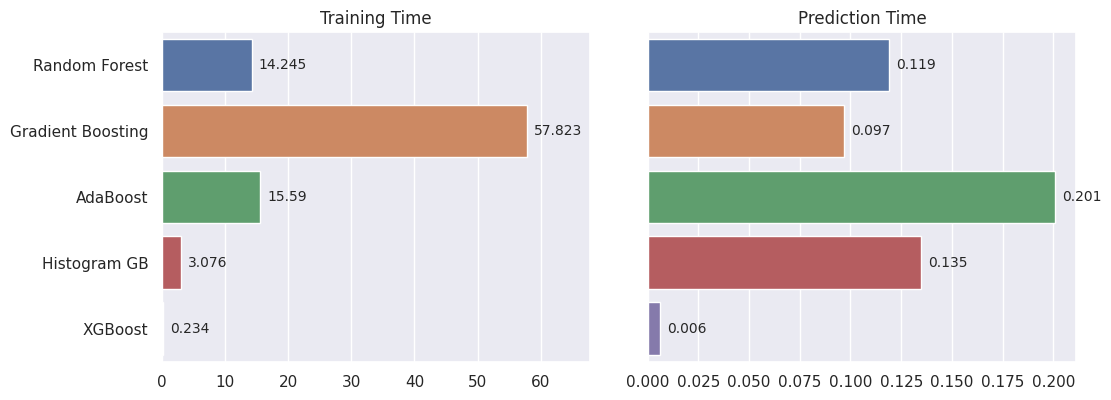

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
fig.tight_layout(w_pad=2.0)

sns.barplot(time_metrics.round(3), x='fit_time', y='model', orient='h', ax=axes[0])
axes[0].bar_label(axes[0].containers[0], size=10, padding=5)
axes[0].set_xlim(0, max(time_metrics.fit_time)+10)
axes[0].set(xlabel=None, ylabel=None)
axes[0].set_title('Training Time')

sns.barplot(time_metrics.round(3), x='predict_time', y='model', orient='h', ax=axes[1])
axes[1].bar_label(axes[1].containers[0], size=10, padding=5)
axes[1].set_xlim(0, max(time_metrics.predict_time)+0.01)
axes[1].set(xlabel=None, ylabel=None)
axes[1].set_title('Prediction Time')

plt.show()

#### Future Predictions
Using Models for Forecasting

In [67]:
def FUTURE_DATASET(raw_data, start_date, end_date):
    '''
    Generate a dataset for future forecasting based on specified date range.

    Parameters
    ----------
        raw_data (DataFrame): The original dataset used for feature creation.
        start_date (string): The starting date for the future dataset.
        end_date (string): The last date to include in the future dataset.

    Return
    ------
        future_dataset (DataFrame): A DataFrame with datetime indices for the specified future period.
    '''

    # Initialize the future dataset with datetime indices
    future_dataset = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq='1H'), columns=['datetime'])
    future_dataset = future_dataset.set_index('datetime')

    # Generate features for the future dataset
    future_dataset = FEATURE_CREATION(future_dataset)

    # Create lag features using historical data
    future_dataset['pm_lag_1Y'] = raw_data.loc[future_dataset.index - pd.Timedelta('365 days')][target].values
    future_dataset['pm_lag_2Y'] = raw_data.loc[future_dataset.index - pd.Timedelta('730 days')][target].values

    return future_dataset

In [68]:
future_df = FUTURE_DATASET(df, start_date='2023-04-01', end_date='2024-03-30')

# Make sure the order of the features is the same as the one we fed to the models.
f_names = ensemble_models['XGBoost'].get_booster().feature_names
future_df = future_df[f_names]

In [69]:
test_predictions = X_test.copy()
future_predictions = future_df.copy()

for model_name, model in ensemble_models.items():
    test_predictions[f'predict_{model_name}'] = model.predict(X_test)
    future_predictions[f'predict_{model_name}'] = model.predict(future_df)

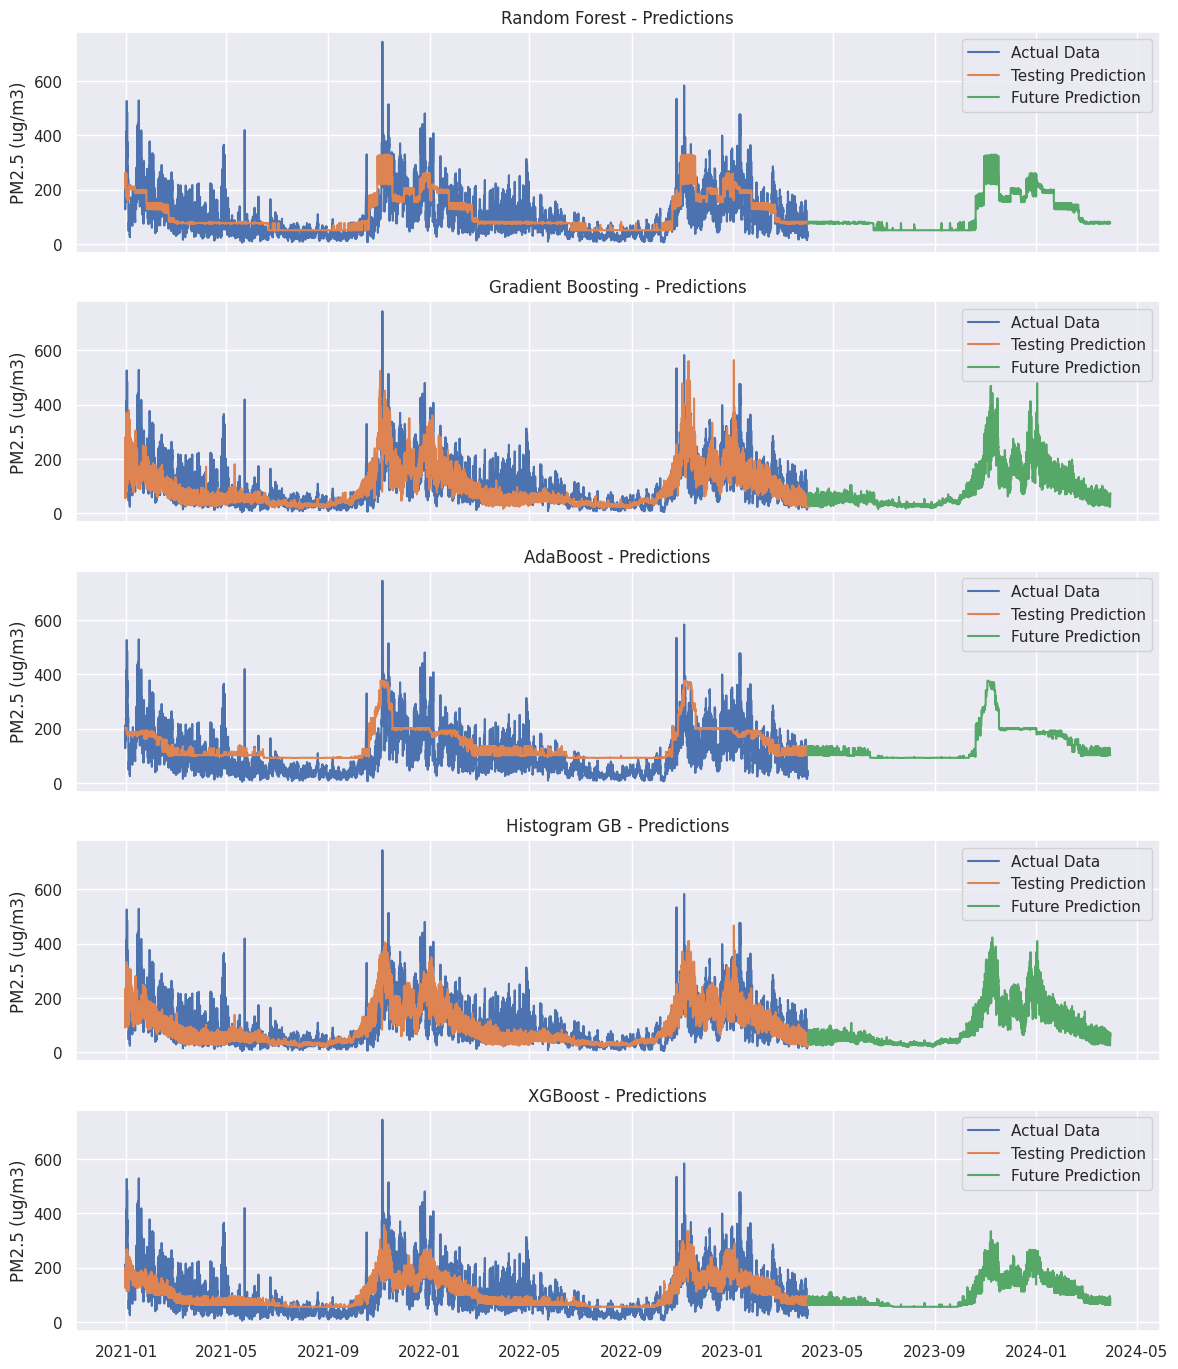

In [70]:
fig, axes = plt.subplots(5, 1, figsize=(12, 14), sharex=True)
fig.tight_layout(pad=2.0)

for index, (model_name, model) in enumerate(ensemble_models.items()):
    sns.lineplot(data=y_test, label="Actual Data", ax=axes[index])
    sns.lineplot(data=test_predictions[f'predict_{model_name}'], label="Testing Prediction", ax=axes[index])
    sns.lineplot(data=future_predictions[f'predict_{model_name}'], label="Future Prediction", ax=axes[index])
    axes[index].set_title(f'{model_name} - Predictions')
    axes[index].set(xlabel=None)

plt.show()

**DEEP LEARNING MODELS**

In [71]:
# Deepcopy to store object's values instead of references.
from copy import deepcopy

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Conv1D, Flatten
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

# Set seed to make Python, NumPy, and TensorFlow deterministic.
tf.keras.utils.set_random_seed(27)

In [72]:
#Repeating the above steps of data merging and cleaning
df_states = pd.read_csv(f'{DATA_PATH}/stations_info.csv')
df_states.drop(columns=['agency', 'station_location', 'start_month'], inplace=True)
df = STATE_DATA_COMB('Delhi')
df = df_index(df)
df = merge(df, reduction_groups)
df = df.dropna(how='all')
df = df.dropna(how='all', axis='columns')
# Threshold value indicating how much of the dataset needs to be not missing.
threshold = 0.6
df = df.dropna(thresh=df.shape[0]*threshold, axis=1)
#Dropping correlated features
df = df.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1)
#Resampling data
df = df.resample('60min').mean(numeric_only=True)
#Outlier Detection and removeal
df['PM2.5 (ug/m3)'] = df['PM2.5 (ug/m3)'].mask(df['PM2.5 (ug/m3)'].gt(950))
df['CO (mg/m3)'] = df['CO (mg/m3)'].mask(((df.index > '2015') & df['CO (mg/m3)'].gt(35)))
df['Ozone (ug/m3)'] = df['Ozone (ug/m3)'].mask(df['Ozone (ug/m3)'].gt(185))
df['NOx (ug/m3)'] = df['NOx (ug/m3)'].mask((
    ((df.index < '2013') & (df['NOx (ug/m3)'].gt(380))) |
    ((df.index > '2015') & (df.index < '2016') & (df['NOx (ug/m3)'].gt(400))) |
    ((df.index > '2016') & (df['NOx (ug/m3)'].gt(450)))
))
#Handling Missing Values
df = df.interpolate(method='pad')
df = df.fillna(df.mean())

Combining a total of 40 files...



In [73]:
# Convert the index of the DataFrame to datetime format
date_time = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')

# Map datetime to timestamp (seconds since the epoch)
timestamp = date_time.map(pd.Timestamp.timestamp)

# Define constants for day and year in seconds
day = 24 * 60 * 60
year = (365.2425) * day

# Create new features based on cyclic encoding of time
df['Day sin'] = np.sin(timestamp * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp * (2 * np.pi / year))

# Define a list of datetime features created
DATETIME_FEATURES = ['Day sin', 'Day cos', 'Year sin', 'Year cos']

# Filter the DataFrame to keep records only after the year 2014
df = df.query('datetime > 2014')

In [74]:
# Splitting the data into train and test
val_split = 0.2
test_split = 0.1
n = len(df)

train_df = df[0:int(n*(1-val_split))]
val_df = df[int(n*(1-(val_split+test_split))):int(n*(1-test_split))]
test_df = df[int(n*(1-test_split)):]

In [75]:
# Data Normalization
# Calculate mean and standard deviation for normalization based on the training data
train_mean = train_df.mean()
train_std = train_df.std()

# Normalize the training data using z-score normalization (subtract mean and divide by standard deviation)
train_df = (train_df - train_mean) / train_std

# Normalize the validation data using the mean and standard deviation calculated from the training data
val_df = (val_df - train_mean) / train_std

# Normalize the test data using the mean and standard deviation calculated from the training data
test_df = (test_df - train_mean) / train_std

def denormalize(data):
    return (data * train_std) + train_mean

**DATA PREPARATION FOR DEEP LEARNING MODELS**

In [76]:
class SEGMENT_GENERATOR():
    def __init__(self, input_width, label_width, label_columns, offset, train_df=train_df, val_df=val_df, test_df=test_df):

        # Store the raw data.
        self.train_df = train_df[label_columns + DATETIME_FEATURES]
        self.val_df = val_df[label_columns + DATETIME_FEATURES]
        self.test_df = test_df[label_columns + DATETIME_FEATURES]

        # Work out the label column indices.
        self.column_indices = {name: i for i, name in enumerate(self.train_df.columns)}
        self.label_columns = label_columns
        self.label_columns_indices = [self.column_indices[feature] for feature in self.label_columns]

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.offset = offset
        self.window_size = self.input_width + self.offset

        # Work out input and label indices.
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.window_size)[self.input_slice]

        self.label_start = self.window_size - self.label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.window_size)[self.label_slice]

        # Initialize the splitted train, val, and test datasets for easy use.
        self._initialize_sets()

    def _initialize_sets(self):
        # Split the datasets into windows
        self._train = self.split_window(self.train_df)
        self._val = self.split_window(self.val_df)
        self._test = self.split_window(self.test_df)

    def __repr__(self):
        # Return a string representation of the SEGMENT_GENERATOR object
        return '\n'.join([f'Total window size: {self.window_size}',
                          f'Input indices: {self.input_indices}',
                          f'Label indices: {self.label_indices}',
                          f'Target features: {self.label_columns}'])

In [77]:
#Convert the provided dataset into windows of features and labels.
def split_window(self, data):
    # Convert the DataFrame to a NumPy array for efficient processing.
    np_df = np.array(data)
    inputs = []  # Initialize a list to collect input windows.
    labels = []  # Initialize a list to collect label windows.

    # Loop through the dataset to extract all possible windows.
    for i in range(len(np_df) - self.window_size):
        # Define the end of the window.
        current_window = np_df[i:i+self.window_size]

        # Use the input_slice attribute to get the inputs from the current window.
        inputs.append(current_window[self.input_slice])

        # Use the label_slice and label_columns_indices to get the labels from the current window.
        labels.append(current_window[self.label_slice, self.label_columns_indices])

    # Convert the lists of inputs and labels to arrays for machine learning models.
    return np.array(inputs), np.array(labels)

# Attach the function as a method to the SEGMENT_GENERATOR class.
SEGMENT_GENERATOR.split_window = split_window

In [78]:
@property
def train(self):
    '''
    Property method to access the training dataset window.

    Returns
    -------
    DataFrame: The training dataset window.
    '''
    return self._train

@property
def val(self):
    '''
    Property method to access the validation dataset window.

    Returns
    -------
    DataFrame: The validation dataset window.
    '''
    return self._val

@property
def test(self):
    '''
    Property method to access the test dataset window.

    Returns
    -------
    DataFrame: The test dataset window.
    '''
    return self._test

# Attach the property methods to the SEGMENT_GENERATOR class
SEGMENT_GENERATOR.train = train
SEGMENT_GENERATOR.val = val
SEGMENT_GENERATOR.test = test

@property
def data_shapes(self):
    '''
    Helper function to showcase the shapes of the sets of the window.
    '''
    print('\n'.join([f'Train:\t {self._train[0].shape} | {self._train[1].shape}',
                     f'Val:\t {self._val[0].shape} | {self._val[1].shape}',
                     f'Test:\t {self._test[0].shape} | {self._test[1].shape}']))

# Attach the property method to the SEGMENT_GENERATOR class
SEGMENT_GENERATOR.data_shapes = data_shapes

@property
def get_model_params(self):
    '''
    Helper function to get and showcase the parameters to be used by the models.

    Returns
    -------
    tuple: Number of time steps, number of input features, number of output features.
    '''

    # Shape of training X vectors is [batch, time, num_layer_units]
    n_steps = self.train[0].shape[1]

    # Shape of input features is [observation, features]
    n_features = self.train_df.shape[1]

    # Shape of target y vector is [batch, time, outputs]
    n_outputs = self.train[1].shape[-1]

    print('\n'.join([f'Number of time steps: {n_steps}',
                     f'Number of input features: {n_features}',
                     f'Number of output features: {n_outputs}']))

    return n_steps, n_features, n_outputs
SEGMENT_GENERATOR.get_model_params = get_model_params

In [79]:
# Initialize a SEGMENT_GENERATOR object to create a single-step window.
single_step_window = SEGMENT_GENERATOR(
    # input_width: Number of time steps the input features will contain.
    # Here, 24 indicates that the model will look at 24 hours of data at a time.
    input_width=24,

    # label_width: Number of time steps the label will contain.
    # Here, 1 indicates that we want to predict 1 hour into the future.
    label_width=1,

    # offset: Number of time steps to offset the label from the input.
    # Here, 1 indicates the model predicts 1 hour into the future.
    offset=1,

    # label_columns: List of column names from the dataset to be used as labels.
    # Here, we're only interested in predicting 'PM2.5 (ug/m3)' values.
    label_columns=['PM2.5 (ug/m3)']
)

# The single_step_window object is now ready to be used with a dataset for training or evaluation.
# It will produce windows of 24 hours of input data to predict 'PM2.5 (ug/m3)' 1 hour into the future.
single_step_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Target features: ['PM2.5 (ug/m3)']

In [80]:
n_steps, n_features, n_outputs = single_step_window.get_model_params

Number of time steps: 24
Number of input features: 5
Number of output features: 1


In [81]:
# Models used
#Vanilla lstm
lstm_vanilla = tf.keras.Sequential([
    Input(shape=(n_steps, n_features)),
    LSTM(32),
    Dense(n_outputs, activation='linear')
])
#Stacked Lstm
lstm_stacked = tf.keras.Sequential([
    Input(shape=(n_steps, n_features)),
    LSTM(32, return_sequences=True),
    LSTM(32),
    Dense(n_outputs, activation='linear')
])
#Bidirectional lstm
lstm_bi = tf.keras.Sequential([
    Input(shape=(n_steps, n_features)),
    Bidirectional(LSTM(32)),
    Dense(n_outputs, activation='linear')
])
#Stacked bi lstm
lstm_stacked_bi = tf.keras.Sequential([
    Input(shape=(n_steps, n_features)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(n_outputs, activation='linear')
])
#cnn
cnn_1d = tf.keras.Sequential([
    Input(shape=(n_steps, n_features)),
    Conv1D(filters=32, kernel_size=(n_steps), activation='relu'),
    Flatten(),
    Dense(n_outputs, activation='linear')
])
#cnn lstm
cnn_lstm = tf.keras.Sequential([
    Input(shape=(n_steps, n_features)),
    Conv1D(filters=32, kernel_size=(n_steps), activation='relu'),
    LSTM(32),
    Dense(n_outputs, activation='linear')
])

In [82]:
#Training and evaluation parameters
# Top level variables
MAX_EPOCHS = 10
PATIENCE = 2
METRIC_NAME = 'mean_absolute_error'
models = {
    "vanilla": lstm_vanilla,
    "stacked":  lstm_stacked,
    "bidirectional": lstm_bi,
    "bidirectional_stacked": lstm_stacked_bi,
    "cnn_1d": cnn_1d,
    "cnn_lstm": cnn_lstm
}

In [83]:
def compile_and_fit(model, window, patience=PATIENCE, num_epochs=MAX_EPOCHS):
    '''
    Compile and fit the given model using the provided training and validation datasets.

    Parameters
    ----------
        model (Sequential): The model to compile and fit.
        window (SEGMENT_GENERATOR): The window object that contains the training, validation, and test datasets.
        patience (int): Number of consecutive epochs with no improvement before early stopping.
        num_epochs (int): Maximum number of epochs for the model to train.

    Returns
    ------
        history (History): TensorFlow history object containing the metric results for each epoch.
    '''

    # Define early stopping callback for training termination
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights=True,
                                                      start_from_epoch=5)

    # Compile the model with Adam optimizer, Mean Squared Error loss, and Mean Absolute Error metric
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=MeanSquaredError(),
                  metrics=[MeanAbsoluteError()])

    # Fit the model to the training data and validate on the validation data
    history = model.fit(window.train[0], window.train[1],
                        validation_data=window.val,
                        epochs=num_epochs,
                        callbacks=[early_stopping])

    return history

In [84]:
# Dictionary to store training histories for each model architecture
histories = {}

# Iterate over each model architecture and train the model
for model_arch, model in models.items():
    # Display progress information
    clear_output(wait=False)
    print(f'Training [{model_arch}] model architecture...')

    # Compile and fit the model using the specified window
    histories[model_arch] = compile_and_fit(model, single_step_window)

Training [cnn_lstm] model architecture...
Epoch 1/10
2026/2026 [==============================] - 13s 6ms/step - loss: 0.0969 - mean_absolute_error: 0.1870 - val_loss: 0.0348 - val_mean_absolute_error: 0.1270
Epoch 2/10
2026/2026 [==============================] - 10s 5ms/step - loss: 0.0617 - mean_absolute_error: 0.1482 - val_loss: 0.0281 - val_mean_absolute_error: 0.1088
Epoch 3/10
2026/2026 [==============================] - 11s 5ms/step - loss: 0.0598 - mean_absolute_error: 0.1449 - val_loss: 0.0230 - val_mean_absolute_error: 0.1016
Epoch 4/10
2026/2026 [==============================] - 11s 6ms/step - loss: 0.0581 - mean_absolute_error: 0.1406 - val_loss: 0.0277 - val_mean_absolute_error: 0.1163
Epoch 5/10
2026/2026 [==============================] - 11s 6ms/step - loss: 0.0576 - mean_absolute_error: 0.1398 - val_loss: 0.0201 - val_mean_absolute_error: 0.0916
Epoch 6/10
2026/2026 [==============================] - 9s 5ms/step - loss: 0.0570 - mean_absolute_error: 0.1386 - val_loss

In [85]:
# List to store the best validation scores for each model architecture
best_scores = []

# Iterate over each model architecture and its training history
for model_arch, history in histories.items():
    # Extract the best validation scores (minimum loss and metric values)
    best_scores.append([model_arch,
                        min(history.history['val_loss']),
                        min(history.history[f'val_{METRIC_NAME}'])])

# Create a DataFrame from the collected best scores
best_scores = pd.DataFrame(best_scores, columns=['Architecture', 'validation_MSE', 'validation_MAE'])

# Set the model architecture as the index of the DataFrame
best_scores = best_scores.set_index('Architecture')

# Sort the DataFrame based on the validation Mean Absolute Error (MAE)
best_scores.sort_values(by=['validation_MAE'])

,validation_MSE,validation_MAE
Architecture,,
stacked,0.012138,0.071138
bidirectional_stacked,0.011828,0.071215
vanilla,0.013045,0.073599
bidirectional,0.013511,0.075528
cnn_lstm,0.018389,0.087211
cnn_1d,0.018515,0.089530


506/506 [==============================] - 1s 3ms/step - loss: 0.0184 - mean_absolute_error: 0.0872


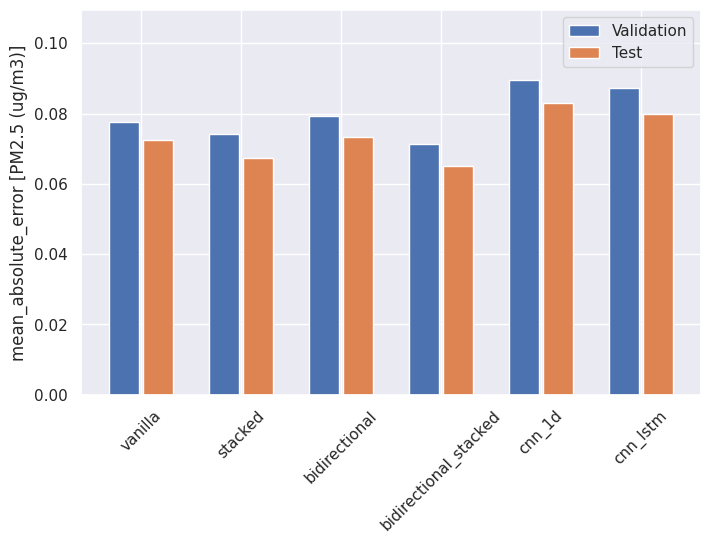

In [86]:
# Dictionaries to store validation and test performance metrics for each model architecture
val_performance = {}
performance = {}

# Iterate over each model architecture and its corresponding model
for model_arch, model in models.items():
    # Evaluate the model on the validation set and store the performance metrics
    val_performance[model_arch] = model.evaluate(single_step_window.val[0], single_step_window.val[1])

    # Evaluate the model on the test set and store the performance metrics (verbose=0 for silent evaluation)
    performance[model_arch] = model.evaluate(single_step_window.test[0], single_step_window.test[1], verbose=0)

# Prepare data for bar chart
x = np.arange(len(performance))
width = 0.3
val_mae = [val_performance[model][1] for model in list(models.keys())]
test_mae = [performance[model][1] for model in list(models.keys())]

# Create a bar chart to visualize validation and test Mean Absolute Error (MAE) for each model
ax = plt.figure(figsize=(8, 5))
plt.ylabel(f'{METRIC_NAME} [PM2.5 (ug/m3)]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')

# Set y-axis limits based on the maximum MAE value
plt.gca().set_ylim(0, max(val_mae + test_mae) + 0.02)

# Set x-axis labels and ticks for each model architecture
plt.xticks(ticks=x, labels=models.keys(), rotation=45)

# Add legend to the chart
_ = plt.legend()

253/253 [==============================] - 1s 2ms/step


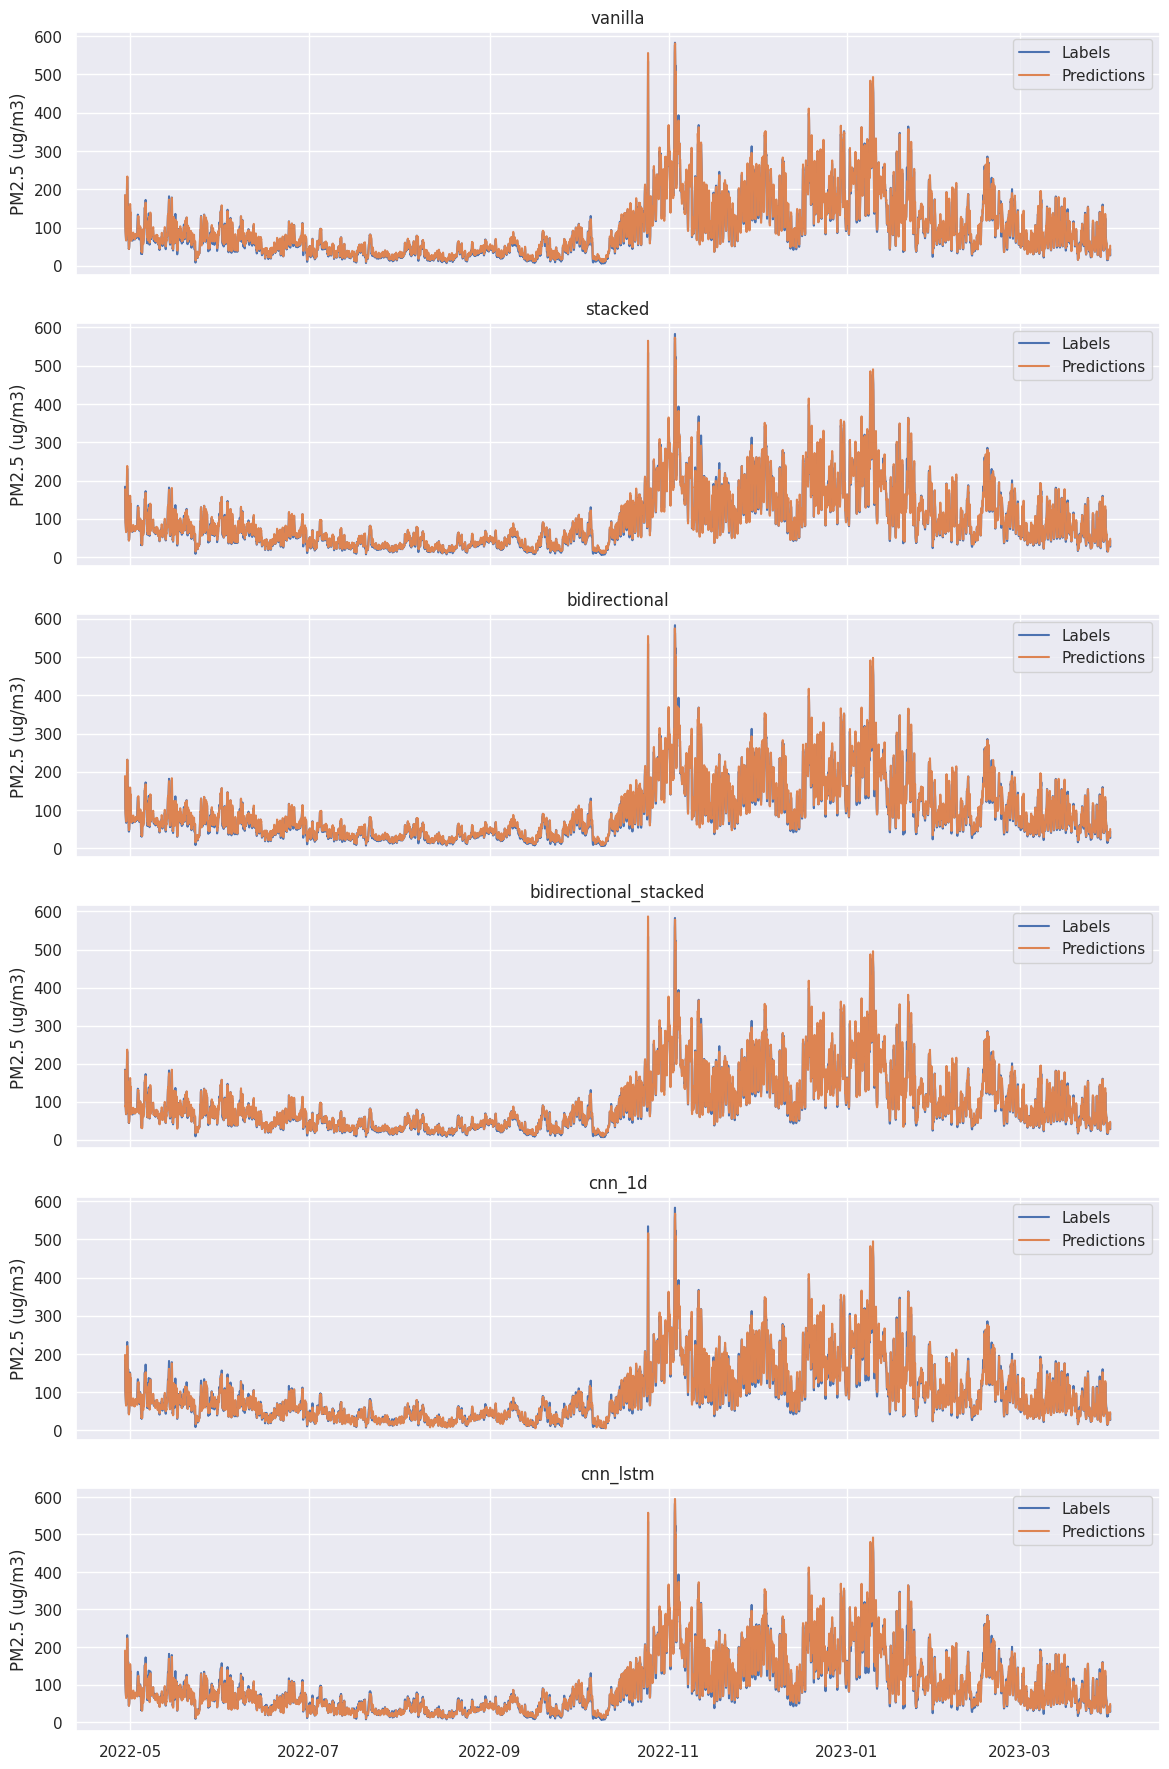

In [87]:
#Predictions
fig, axes = plt.subplots(len(models), 1, figsize=(12, 3*len(models)), sharex=True)
fig.tight_layout(pad=2.0)

for index, (model_name, model) in enumerate(models.items()):
    # Use models to make predictions on the test set
    predictions = model.predict(single_step_window.test[0])
    predictions = pd.DataFrame(predictions, index=test_df.index[single_step_window.input_width:-1], columns=single_step_window.label_columns)

    # Denormalize the records to their actual values
    predictions_denormalized = denormalize(predictions)
    test_df_denormalized = denormalize(test_df)

    # Plot the actual data, as well as the prediction data
    sns.lineplot(data=test_df_denormalized[24:], x=test_df_denormalized.index[24:], y=single_step_window.label_columns[0], label="Labels", ax=axes[index])
    sns.lineplot(data=predictions_denormalized, x=predictions_denormalized.index, y=single_step_window.label_columns[0], label="Predictions", ax=axes[index])
    axes[index].set_title(model_name)
    axes[index].set(xlabel=None)

plt.show()

In [88]:
#Model Tuning Using BayesianOptimizer
def Tuned_Model(hp):
    '''
    Build a recurrent neural network (RNN) model with hyperparameter tuning using Keras Tuner.

    Parameters
    ----------
        hp (HyperParameters): Hyperparameter tuning space.

    Returns
    -------
        Sequential: Compiled RNN model with tuned hyperparameters.
    '''

    # Create a sequential model
    model = tf.keras.Sequential()

    # Add input layer with specified shape
    model.add(Input(shape=(n_steps, n_features)))

    # Tune number of units for the first LSTM layer
    model.add(LSTM(units=hp.Int("lstm1_units", min_value=24, max_value=64, step=8), return_sequences=True))

    # Tune number of units for the second LSTM layer
    model.add(LSTM(units=hp.Int("lstm2_units", min_value=24, max_value=64, step=8)))

    # Tune whether to use an intermediate dense layer
    if hp.Boolean("dense_layer"):
        # Add dense layer with tunable number of units and ReLU activation
        model.add(Dense(units=hp.Int("dense_units", min_value=24, max_value=32, step=8), activation="relu"))

    # Add output layer with linear activation
    model.add(Dense(n_outputs, activation='linear'))

    # Compile the model with Adam optimizer, Mean Squared Error loss, and Mean Absolute Error metric
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=MeanSquaredError(),
                  metrics=[MeanAbsoluteError()])

    return model

In [89]:
# Initialize a BayesianOptimization tuner for hyperparameter tuning using Keras Tuner
# Set the objective as 'val_loss', maximum number of trials to 10, and specify the save directory
# and project name for the tuner
tuner = kt.BayesianOptimization(Tuned_Model,
                                objective='val_loss',
                                max_trials=3,
                                directory='keras_tuner',
                                project_name='stacked_lstm')

# Define early stopping for the tuner based on validation loss
tuner_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min',
                                                  restore_best_weights=True,
                                                  start_from_epoch=5)

# Perform hyperparameter search using the tuner on the training and validation datasets
tuner.search(single_step_window.train[0], single_step_window.train[1], epochs=10,
             validation_data=single_step_window.val, callbacks=[tuner_stopping])

# Retrieve the optimal hyperparameters from the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build a hypermodel using the optimal hyperparameters
hypermodel = tuner.hypermodel.build(best_hps)

# Display the summary of the hypermodel architecture
hypermodel.summary()

Trial 3 Complete [00h 03m 26s]
val_loss: 0.012277871370315552

Best val_loss So Far: 0.011889978311955929
Total elapsed time: 00h 09m 15s
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24, 24)            2880      
                                                                 
 lstm_3 (LSTM)               (None, 24)                4704      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 7609 (29.72 KB)
Trainable params: 7609 (29.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [90]:
#Retraining the model
hypermodel.fit(single_step_window.train[0], single_step_window.train[1],
               validation_data=single_step_window.val,
               epochs=MAX_EPOCHS,
               callbacks=[tuner_stopping])

Epoch 1/10
2026/2026 [==============================] - 20s 8ms/step - loss: 0.0993 - mean_absolute_error: 0.1840 - val_loss: 0.0264 - val_mean_absolute_error: 0.1161
Epoch 2/10
2026/2026 [==============================] - 16s 8ms/step - loss: 0.0563 - mean_absolute_error: 0.1345 - val_loss: 0.0174 - val_mean_absolute_error: 0.0864
Epoch 3/10
2026/2026 [==============================] - 16s 8ms/step - loss: 0.0542 - mean_absolute_error: 0.1305 - val_loss: 0.0171 - val_mean_absolute_error: 0.0886
Epoch 4/10
2026/2026 [==============================] - 16s 8ms/step - loss: 0.0527 - mean_absolute_error: 0.1276 - val_loss: 0.0165 - val_mean_absolute_error: 0.0840
Epoch 5/10
2026/2026 [==============================] - 16s 8ms/step - loss: 0.0520 - mean_absolute_error: 0.1268 - val_loss: 0.0150 - val_mean_absolute_error: 0.0784
Epoch 6/10
2026/2026 [==============================] - 16s 8ms/step - loss: 0.0512 - mean_absolute_error: 0.1254 - val_loss: 0.0141 - val_mean_absolute_error: 0.075

In [95]:
results = hypermodel.evaluate(single_step_window.test[0], single_step_window.test[1])
print(results)

253/253 [==============================] - 2s 6ms/step - loss: 0.0105 - mean_absolute_error: 0.0710
[0.010516750626266003, 0.07101470232009888]


** Multi Output Model**

In [92]:
multi_step_window = SEGMENT_GENERATOR(input_width=24, label_width=24, offset=24,
                                    label_columns=['PM2.5 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)', 'NOx (ug/m3)'])
multi_step_window
n_steps, n_features, n_outputs = multi_step_window.get_model_params

Number of time steps: 24
Number of input features: 8
Number of output features: 4


In [93]:
multi_lstm_stacked = tf.keras.Sequential([
    Input(shape=(n_steps, n_features)),
    LSTM(64, return_sequences=False),

    # Shape => [batch, 1, out_steps*features]
    Dense(n_steps*n_outputs, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([n_steps, n_outputs])
])
multi_history = compile_and_fit(multi_lstm_stacked, multi_step_window)

Epoch 1/10
2025/2025 [==============================] - 16s 7ms/step - loss: 0.3530 - mean_absolute_error: 0.3717 - val_loss: 0.1938 - val_mean_absolute_error: 0.2637
Epoch 2/10
2025/2025 [==============================] - 12s 6ms/step - loss: 0.2959 - mean_absolute_error: 0.3337 - val_loss: 0.1812 - val_mean_absolute_error: 0.2552
Epoch 3/10
2025/2025 [==============================] - 11s 5ms/step - loss: 0.2832 - mean_absolute_error: 0.3257 - val_loss: 0.1748 - val_mean_absolute_error: 0.2507
Epoch 4/10
2025/2025 [==============================] - 12s 6ms/step - loss: 0.2744 - mean_absolute_error: 0.3208 - val_loss: 0.1764 - val_mean_absolute_error: 0.2509
Epoch 5/10
2025/2025 [==============================] - 12s 6ms/step - loss: 0.2679 - mean_absolute_error: 0.3173 - val_loss: 0.1672 - val_mean_absolute_error: 0.2448
Epoch 6/10
2025/2025 [==============================] - 11s 6ms/step - loss: 0.2619 - mean_absolute_error: 0.3145 - val_loss: 0.1670 - val_mean_absolute_error: 0.243

252/252 [==============================] - 1s 2ms/step


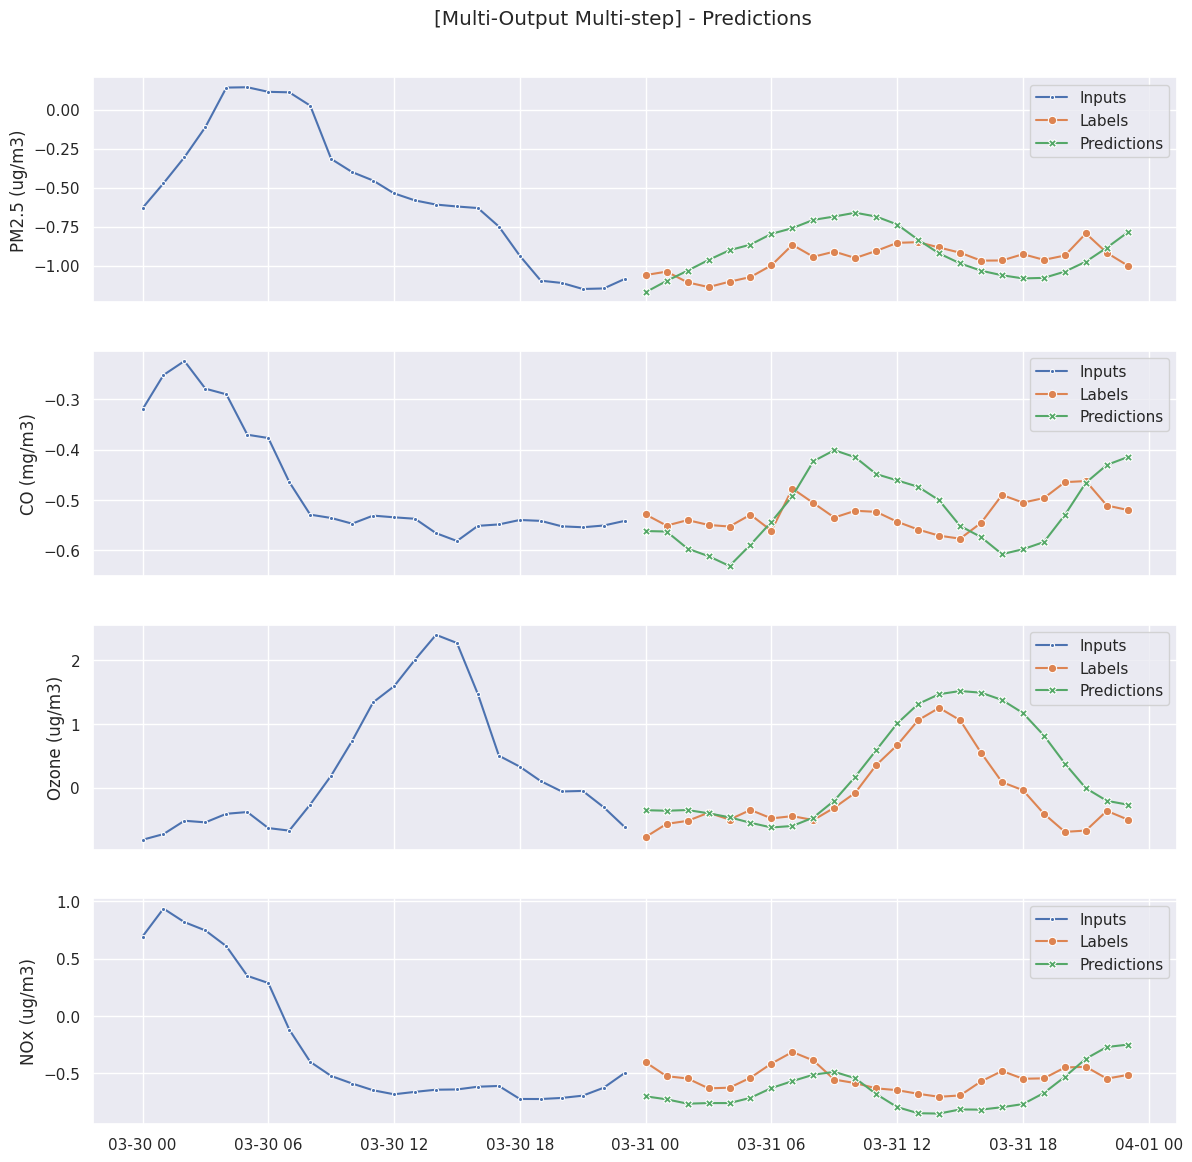

In [94]:
#Plotting the output
def multi_predictions_plot(model, window, title):
    # Get properties of plotting.
    is_multi_output = len(window.label_columns) > 1

    # Get test set predictions.
    test_predictions = model.predict(window.test[0])
    test_predictions = pd.DataFrame(test_predictions[-1], index=window.test_df.index[window.input_width:][-window.input_width:], columns=window.label_columns)

    # Set figure properties.
    fig, ax = plt.subplots(len(window.label_columns), 1, figsize=(12, 3*len(window.label_columns)), sharex=True)
    fig.suptitle(title)
    fig.tight_layout(pad=2.0)

    input_width = window.input_width
    input_slice = slice(-input_width*2, -input_width)
    label_slice = slice(-input_width, None)

    for index in window.label_columns_indices:
        sns.lineplot(data=window.test_df[input_slice], x=window.test_df.index[input_slice], y=window.label_columns[index],
                     label="Inputs", marker='.', ax=ax[index])
        sns.lineplot(data=window.test_df[label_slice], x=window.test_df.index[label_slice], y=window.label_columns[index],
                     label="Labels", marker='o', ax=ax[index])
        sns.lineplot(data=test_predictions, x=test_predictions.index, y=window.label_columns[index],
                     label="Predictions", marker='X', ax=ax[index])

    # Remove x label fom plot.
    ax = [x.set(xlabel=None) for x in ax]
    plt.show()
multi_predictions_plot(multi_lstm_stacked, multi_step_window, title='[Multi-Output Multi-step] - Predictions')